<img align="center" style="max-width: 900px; height: auto" src="./banner.png">

<img align="right" style="max-width: 200px; height: auto" src="hsg_logo.png">

##  Lab 06 - Attention

Machine Learning, University of St.Gallen (HSG), Spring Term 2024

The lab environment of the **Machine Learning** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this lab, we will build our own GPT model, multihead self-attention method will be introduced.

<img align="center" style="max-width: 700px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/2021-Alan-D-Thompson-AI-Calendar-Timeline-Rev-2a.png" />

(Source: https://lifearchitect.ai/timeline/)

### Lab Objectives:

After today's lab, you should be able to:

> 1. Understand how **Multi-head Self Attention** works.
> 2. Build our own GPT model.  
> 3. Compare our GPT model with LSTM.
> 4. Use GPT model to do text generation on Shakespeare's plays.

### Setup of the Lab Environment

Similar to the previous labs, we need to import a couple of Python libraries:

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import math
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import urllib
from urllib.request import urlopen
import io

ModuleNotFoundError: No module named 'torch'

Enable inline Jupyter notebook plotting:

In [2]:
%matplotlib inline

Ignore potential library warnings:

In [3]:
import warnings
warnings.filterwarnings('ignore')

Set random seed of all our experiments:

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

## 1. Dataset

For this lab, we use **tiny_shakespeare** as our dataset. This dataset has 40,000 lines of Shakespeare from a variety of Shakespeare's plays.

We first split the dataset into training and evaluation sets.

In [5]:
text = urlopen("https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/tiny_shakespeare.txt").read().decode("utf-8") 

In [6]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


We set the fraction of training set to **90%** of the original dataset, the rest **10%** is for evaluation:

In [7]:
total_raw_chars = len(text)
train_text = text[:int(total_raw_chars * 0.9)]  # 90% of the text for training
eval_text = text[int(total_raw_chars * 0.9):]   # 10% of the text for evaluation
print(f"Traing text length: {len(train_text)}")
print(f"Eval text length: {len(eval_text)}")

Traing text length: 1003853
Eval text length: 111540


But before we dive into the Dataset code, we first need to create some variables to record the information of our dataset.

In [8]:
chars = ['#'] + sorted(list(set(text))) # Add '#' as an indicator of the end of the sentence. 
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)  # How many unique characters are there in the text?

Also set our training hyper-paramaters:

In [9]:
batch_size = 64 
num_epochs = 5  
learning_rate = 0.00001 # larger learning rate will cause overfitting
seq_length = 100 # how long is the sequence that we want to retrieve from the dataset?

Now let's build our Dataset. The Dataset is actually very similar to the Dataset used in the LSTM lab session.

In [10]:
class ShakespeareDataset(Dataset):
    def __init__(self, text_list, seq_length):
        # text_list: text to be used for training or evaluation
        # seq_length: how long is the sequence that we want to retrieve from the dataset?

        self.text = text_list
        self.seq_length = seq_length
 
    def __len__(self):
        # Return the total number of setences that the dataset includes
        return len(self.text) - self.seq_length
        
    def __getitem__(self, index):
        # Return a random substring with its correponding target.
        sequence = self.text[index:index + self.seq_length + 1]
        target = self.text[index + 1:index + self.seq_length + 1] + '#'
        
        return [torch.tensor([char_to_int[c] for c in sequence], dtype=torch.long),
        torch.tensor([char_to_int[c] for c in target], dtype=torch.long)]

Create the training and evaluation Datasets and their respective dataloaders:

In [11]:
train_dataset = ShakespeareDataset(text_list=train_text, seq_length=seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

eval_dataset = ShakespeareDataset(text_list=eval_text, seq_length=seq_length)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## 2. GPT (Generative Pre-trained Transformer)

<div>
<img align="center" style="max-height: 500px; width: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/GPT1.png" />
</div>

#### 2.1. Self-Attention

For RNN models (e.g. LSTM), we assume that the current time step depends on the most recent time steps. But this can be limiting when dealing with long sequences or sequences with complex dependencies between elements.

On the other hand, the Transformer learns dependencies from the data using the self-attention method, which is why it has been successful in handling various kinds of data.

In short, self-attention allows the model to weight different parts of the input sequence, based on their importance for the current prediction. This can model the network better capture long-range dependencies and contextual information.

<div>
<img align="center" style="max-width: 600px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/Screen_Shot_2020-05-24_at_7.58.36_PM.png" />
</div>
(Source: Bahdanau et al. 2015)

To compute self-attention, the input sequence is first mapped to query, key, and value vectors. These vectors are then used to compute a weight (score) for each input element, based on how well it matches the query vector. The weighted sum of the value vectors is then used as the output of the self-attention layer. This way, the network can attend to different parts of the input sequence depending on the current query vector.

We divide the same element into three parts: query, key and value. In order to organize information.

Query: What kind of information we want to retrieve.<br>
Key: All the information in the data.<br>
Value: The information that meets our requirement. 

In [12]:
from IPython.display import Video
Video("https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/selfAtt.mp4", width=700)

(Source: https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

We first need to calculate the attention score that determines the relevance between the keys and values. There are various methods to calculate it, in this lab session, we use Scaled Dot Product (Vaswani et al. 2017). The scaling factor prevents the dot product from getting too large, which can cause the softmax function to approach either 0 or 1, making the gradients too small or too large. 

$$score = attn(q,k) = \frac{q^T \cdot k}{\sqrt{|k|}}$$

Then we use scores to weight the value vectors.

$$attn\_output = score \cdot v$$

#### 2.2. Multi-head Self-Attention

<div>
<img align="center" style="max-width: 700px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/maxresdefault.jpeg" />
</div>

(Source: https://youtu.be/mMa2PmYJlCo)

The motivation of multi-head self-attention is to apply different attention layer/filter on the same input, and each layer/filter can attend to different aspects of the input data in parallel. This strategy allows the model to capture a richer set of relationships and dependencies. 

In [18]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        # embed_dim: the dimension of the input vectors
        # num_heads: the number of heads in the multihead attention
        
        self.num_heads = num_heads
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        
        self.key = nn.Linear(embed_dim, embed_dim)      # key projector to get key vectors
        self.value = nn.Linear(embed_dim, embed_dim)    # value projector to get value vectors
        self.query = nn.Linear(embed_dim, embed_dim)    # query projector to get query vectors
        
        self.proj = nn.Linear(embed_dim, embed_dim)     # project the concatenated multihead attention output to the original dimension
        
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x.shape == (batch_size, len, embed_dim)
        batch_size = x.size(0)
        x_len = x.size(1)
        
        k_t = self.key(x).reshape(batch_size, x_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, x_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, x_len, self.num_heads, -1).transpose(1, 2)
        # kt.shape == (batch_size, num_heads, embed_dim/num_heads, len)
        # v.shape == (batch_size, num_heads, len, embed_dim/num_heads)
        # q.shape == (batch_size, num_heads, len, embed_dim/num_heads)
        
        attn = torch.matmul(q, k_t) / math.sqrt(q.size(-1)) # attention score
        # attn.shape == (batch_size, num_heads, len, len)
        
        # use the mask to prevent the model from attending to the future tokens
        mask = torch.tril(torch.ones(x_len, x_len)).unsqueeze(0).unsqueeze(0).to(x.device) # don't forget to move the mask to the same device as the input
        attn = attn.masked_fill(mask == 0, float("-inf"))
        
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        # attn.shape == (batch_size, num_heads, len, len)
        
        # attn is the normalized attention scores
        y = torch.matmul(attn, v)
        # y.shape == (batch_size, num_heads, len, len)
        
        y = y.transpose(1, 2)
        # y.shape == (batch_size, len, num_heads, head_dim)
        
        y = y.reshape(batch_size, x_len, -1)
        # y.shape == (batch_size, len, embed_dim)
        
        y = self.proj_dropout(self.proj(y))
        return y, attn  # we also return the attention scores for visualization

#### 2.3. Feed Forward Layer

In short, Feed Forward Layer is just a bunch of nonlinear layers.

In [19]:
class FeedFoward(nn.Module):

    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

#### 2.4. Block

<div>
<img align="center" style="max-height: 500px; width: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/GPT_ours.png" />
</div>

Inspired by https://github.com/karpathy/ng-video-lecture/blob/52201428ed7b46804849dea0b3ccf0de9df1a5c3/gpt.py, we slightly change the architecture, it can improve the final performance a little bit.

**Layer Normalization (LN)**: LN is used in deep learning to improve the training stability and convergence speed of neural networks. It addresses the problem of internal covariate shift, which occurs when the distribution of each layer's inputs changes during training due to the continuous update of the model's parameters. This can lead to slower convergence and make it challenging to train deep networks.

Let's say we have two inputs (batch size 2):

$\text{sample1} = [0.5, 0.7, 0.3, 0.6]$ <br>
$\text{sample2} = [0.2, 0.9, 0.6, 0.3]$

$\mu_{sample1} = (0.5+0.7+0.3+0.6)/4 = 0.525$ <br>
$\mu_{sample2} = (0.2+0.9+0.6+0.3)/4 = 0.5$

$\sigma_{sample1} = \sqrt{[((0.5 - 0.525)^2 + (0.7 - 0.525)^2 + (0.3 - 0.525)^2 + (0.6 - 0.525)^2)]/4}$ <br>
$\sigma_{sample2} = \sqrt{[((0.2 - 0.5)^2 + (0.9 - 0.5)^2 + (0.6 - 0.5)^2 + (0.3 - 0.5)^2)]/4}$

$\text{sample1}_{norm} = (\text{sample1}-\mu_{sample1}) / \sigma_{sample1}$ <br>
$\text{sample2}_{norm} = (\text{sample2}-\mu_{sample2}) / \sigma_{sample2}$

In [20]:
class Block(nn.Module):

    def __init__(self, embed_dim, num_heads, dropout):
        # n_embd: embedding dimension
        # n_head: the number of heads we'd like
        
        super().__init__()

        self.sa = MultiheadAttention(embed_dim, num_heads, dropout)
        self.ffwd = FeedFoward(embed_dim, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, attn = self.sa(self.ln1(x))
        x = x + attn_output
        x = x + self.ffwd(self.ln2(x))
        
        return x, attn

#### 2.5. Position Embedding

Consider these two sentences:<br>
1. "The girl saw the dog in the park." <br>
2. "In the park, the girl saw the dog."<br>

The position can make the meaining different.

<div>
<img align="center" style="max-height: 500px; width: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/position_embed.png" />
</div>

(Source: https://towardsdatascience.com/concepts-about-positional-encoding-you-might-not-know-about-1f247f4e4e23)

#### 2.6. Wrap everything together to build GPT

In [21]:
class GPTLanguageModel(nn.Module):

    def __init__(self, embed_dim, num_heads, n_layer, pos_len, dropout=0.2):
        super().__init__()

        # embed_dim: the dimension of the input vectors
        # num_heads: the number of heads in the multihead attention
        # n_layer: the number of blocks we'd like to stack
        # pos_len: the maximum length of the position_embedding, should be at least larger than the maximum length of the input sequence, which is seq_length+1 (dont forget the <#> token)
        # dropout: the dropout rate
        
        self.pos_len = pos_len
        
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dim) # like LSTM, we first need to embed the tokens with a lookup table
        self.position_embedding_table = nn.Embedding(pos_len, embed_dim) # we also need to embed the position with a lookup table
        
        self.blocks = nn.Sequential(*[Block(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout) for _ in range(n_layer)])   # how many blocks we'd like to stack
        
        self.ln_f = nn.LayerNorm(embed_dim) # final layer norm
        
        self.lm_head = nn.Linear(embed_dim, vocab_size) # the final linear layer to get the logits

        # reference: https://github.com/karpathy/ng-video-lecture/blob/52201428ed7b46804849dea0b3ccf0de9df1a5c3/gpt.py#L41
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_seq, targets=None):
        B, T = input_seq.shape  # B: batch size, T: sequence length

        tok_emb = self.token_embedding_table(input_seq) # (B,T,C), map the tokens to their embeddings
        pos_emb = self.position_embedding_table(torch.arange(T, device=input_seq.device)).unsqueeze(0).repeat(B, 1, 1) # (B,T,C), map the positions to their embeddings
        
        x = tok_emb + pos_emb # (B,T,C) # combine the token and position embeddings
        
        attn_list = []
        # we save the attention scores for visualization
        for block in self.blocks:
            x, attn = block(x) # (B,T,C)
            attn_list.append(attn)
        
        x = self.ln_f(x) # (B,T,C)

        logits = self.lm_head(x) # (B,T,vocab_size), get the logits

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss, attn_list

    def generate(self, prompt, char_to_int, int_to_char, device, max_new_tokens=300, return_attention=False):
        # generate new text based on the prompt
        # prompt: a list of tokens, (B, T)
        # max_new_tokens: the maximum number of tokens to generate
        
        generated_text = prompt
        prompt_idx = torch.tensor([char_to_int[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)
        
        for _ in range(max_new_tokens):
            prompt_idx_cond = prompt_idx[:, -self.pos_len:] # crop prompt, in case it's longer than pos_len
            
            # get the predictions
            logits, loss, attn_list = self(prompt_idx_cond)
            
            # we only need the logits for the last token
            logits = logits[:, -1, :]
            
            # convert logits to probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            
            # sample from the distribution
            predicted_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # append new token to the original prompt
            prompt_idx = torch.cat((prompt_idx, predicted_token), dim=1) # (B, T+1)
            
            # Conver the token ID to string and add it to `generated_text`
            if int_to_char[predicted_token[0].item()] == "#": 
                break
            
            generated_text += int_to_char[predicted_token[0].item()]
        
        if return_attention:
            return generated_text, attn_list
        return generated_text

## 3. Training

#### 3.1. Training setup

We first define some hyperparameters.

In [22]:
# define the hyperparameters for GPT
embed_dim = 384
num_heads = 6
n_layer = 6
pos_len = seq_length + 1 # dont forget the <#> token
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Now we define our GPT model.

In [23]:
gpt_model = GPTLanguageModel(embed_dim=embed_dim, num_heads=num_heads, n_layer=n_layer, pos_len=pos_len).to(device)

Sometimes it's useful to see how big our model is.

In [ ]:
# count the number of trainable parameters
trainable_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

<img align="center" style="max-width: 700px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/model_size_history.png">

source: [Link](https://vega.github.io/editor/#/url/vega-lite/N4IgrgzgpgTgtlALgQxALlFOAjKATAeQAdEBLAewDsJ1REALLKdEAM1IDcl7SZEBPKKQDm9RCAC+EgDQgAxlXbDaIDqSgB3FQsplKYcpADqpPA3QAWAAxXZOvQcgAJIaPFoAzDZkhkAD1IaDBAAG2RcEIAxKkQAZVIAL2Y0ACZbEDJEEKho3Xik9C8fbOEoSjwVYRhkPHVdABky4XM0a3SqmrrEABUeOQBrSigIIK9ZMIjcuMTkgEYADlkIfhxyEPy5sYzSLJyYjfQ0qXHkQRh0AG1QPGQUFUpkBBYblABaPCtsBdmAdisLWYATh+rGwgJqUFmHlYcisUCgyDk8wsN2YPjgyBg-RUAiIyRARHIpF0IFk7BC2QqaFYyBC0CWM3QsyOsjKClqlGUwQUIXI52CuPxlHIcGJtNJbHUISpIAAIiLkMTJLI8EhFSEcfw8SxhaKHhqyVKZfKMUqfOQiIidvxtFRamQqCoOLSwHMllBsnIHZQWNBPYg+TYfsrVC7klYAHQpHwQejIbUCrVCkVig2Sj3GhVm2QBtZkIiXOhJnUp-US9gZlixfgQRBYZVFhMgXWp8tGlgAJSgrFgbLR0kb+LrcEJ1TTFelLAACmBsCFSHJbhRKAACF79wcsACOYGQuh2S64bcraBAU8xjyQsBoZL5GPcIAjsw3GWLp5bZcNJ7lWZ9EgAurIfiak2w6juKX6TqeM5zguS5UGutz9iANqJk2O57pkh7MLI-iBCorB3rcLBPshE4yue1QIHWMA3iAECLtkKh4L+lyzNIXg2Fx3FcYBr5NryyhSD4jAiGI6AAGw2O6-rLiofpQF6gZWMGaH4nAYAhGQx7SkEFw-qaPp8dgxIyiUZQVMc2y7NOF7UbAK4KGAugruQrArgAsvUK7LLWWAQCuDAwIYoiBaQTyyBopgtLMszeAOIAvKgwQPE8p5Ja8ACsIIpICeDYFYKQWKwEmZXgFjIB4HhQB4KQSXIKSQqweCZTYFghhiWIgfi85DBKcjzgWaCIDArqyISxLuDSdJQEsI3kP0UCysgsZsbYmX-j4bLkByXKgDyfLdSWeoQemUEGYqPrjFApTlOg+gUksfLuPpADil50fUe7CLupQSgQDCwBKABqgRyZtsgWlaAi2uUOxycEzohK6TIyYp3q+h66PKcGPhIyjaCRtGSxxgmm7vqWp3kSwJqXRK5l3WgD0hD4wFqSwYF8lT7bQbO86Lt6iF1iGqHkyAGH7igZBHpBFF2VetGSFIfEwMMaxHsEDG0sk+1rIdp6mVAeLlGU4gk-G+KG8bqoklZAAkDGMBiLBiIgRAQGgAD0ntcMIyARsIOz0LOEYUJ7jtYMgPs3cgrzznWPsWBG8xPhGABWECOiqtwrUgQTXDn7yfN8fwAsCoLgqqUIwnCCJIiiyDJFcIDVn5cBVgAcgAgh2ADC-0wH7lCJPBlAABQQAAlCwEpd2ADB8hP0+nh5mJqKuHnEhA-Q2rIXdEEQwWIvQM+yLTSqngDjDnLI3QrdiK-IEkPnq8Syi39UxJv652Bp+jnD4glAASUoANSAy5HIwB2LAUgyUQASk3tkWsVBAGyBgvzUeQt8RAkyikV4VhZj4PmN0GwhMrBkIlF2HsqtQH4i7iuDuUAwBjleF3fU5AfpQBXL3WkchNK3D5CuAAQrnPAK4wCElXMgFcU5grYHCKQeO-BPI7Q9K5dyXZiSERgHIJgJJZD1GJA-eBsgnCmBtiuMIZwggmLPPLGiQRrAf0ut-BQI555cLHpEeoBApyxGXrYkB1C+yORFEQDxK4vE+L8QEiU3RP7D05ELXOD44kJO-klaAiAfIzEiUlCaugp6nxAAAUR3JwbWLkRouKSWQBAkT6CGForE2QQTey0LCvUsecAimnjSTU4QySsk5OfmPV6QiWkgHiQM0JtZIlpDSCuAAqrEWUsSZCgFbsOKsHp3IEEHnuRI38tn1lkPsoeI9vRL2KXPBeMBrmniER6OAMQVyRExNkZRe4xFGGGJ87hYQup7wPkfOQJ8+ln1YqeUGEA5K33vrZRANFVyqwUMIYeGNnFfySeQX+-8NaBNAcjWFCE5BQJorA4piDhgBj6hCs8fM4KC3XCwHBFh8GEIISQ8hpCbCUO7O03RLBXplFgLSS5EC3IrktEi2AKLFIcIxRA4kK5pF+lYK8PkFyEjf18tsgxRiXZIvdl7T2eAQgRkRHACMWqzVEk9nFJ8swLCZQdS63BgIUhPndV4QEEozF4AsVY68xTKKXgcYcFImUsWJMGW48JdZIneN8f44pbSaG6NCe4xNUSU2TOmdiwZmSkDFILbGoZSARmePyUSQpkyylgAqdkKp6TanhU8Y05hvTCXBI6XUzxPT82tqLTnYZsLRnjKHTMhQcyx4LKsMs1Z6yEonPbvS85hyEijweS3b5sDuF8nApikAtzGn3O7UYCMK5L3CMpJnWaK4gFXqEcFDQsbZ4gvIMfYp58fTQrBlnKZCLTy9zjNUL0DlUWKvhoBst39cV-y9AAtNRLwGkvJTAuBCDFE0pQaGxlAsIEstPDgwEHKOXcrIRQ2QVDBX4nPLKmA8q0VKoQt8lcqtOhJOwMojEYLiQ4RAIYygxjXYmu9hoSTEZ40eJgDawens5AQHNZ7Q+5BdH4DfhAV4mIyADSgJ7ZA7B3YOsBJlQEntWqZVaikKNDqUgEDgB3LcHcJIdgsB4f15iyiWNOCG+lYb7KK1SBJLYcGkkyZzcmmJKHe2Zsi546Lqb6XhZHSgLJpbh0VuyeO6tOcCmIG7RKBtTbTaBSy-2hpTSiutMoHFrhlXuk1amVl4tOXcljImZl6d5BZ3zsXWsmeGyW41m2aeWIjxXQhAYUwsc3DGADBDWcg5w8t1XOa6exe3au58GDjAFc9Qr0TY0h6D9anv30t-cKj6cTgMgFA4pRaisY3wbxUhglwDUMktXGS6BUCsOyGpcgultj0FMqI0hVlZmyMEIo7ynlVh+X1arCKLhtYwC1GGCuFVfGeBDEsQiJj39wG1MYCuP29SpVgse0toThr6UBqDX54LIAO6ey7hKQLCsgizAki9iLYSIm5pi-S9NISEtJuicl2xqXsvdcLdlqteT8u1sK-W8pSMyvVIV41ztzSWB+tq-VzpA7u0-AjJlfpCu2tK861OhXM7slzsKgulZg2+nDdXSwLusou71CAR3EpA9tXbo2-PM9O6TB4Ffaq8oK4nBuVYGd0F4LbFXf-d92729EXIo4wq9FMGrotZmQh-FqCQAgLAd9yBf3KX0qB7S8vYPCMIWIyAIEUlyNcvh9RkAtGM3l+E6J41HtvaBAtbWPc2i8ARnwGAT2AA-KK0fyAaFUxbWiimO9WBqPGaWwwoqIH45yCMRA8BJ9Md51cwaWec-sf534-O42C6i1LyZYuOkS+F9Lq35a2vy7-1HUrVy2VxQAK27VmAjBsBKQAGpCpisNdKlsltdy1ddqt386s6MTdIlB0ACMkgD2sJ0usUsstHd5kXcBtl1NlRt6xoJYBdESBgoi8N1VtQ9JlNtz12DP0Ls08oUQAYU4UgNs9HkxQYBlEBoVpYV2AW8i9ZdS93ty9K9iUIFfsKUAcQAG88MAsCNME28O88FYdu8Ede9+8+xpwoFQFSAiAkF1EZtmEdp+BUoFwIBpAVxYhLQ+A9xhFyAFoXCZsNAVwABNPkfoSJfQ6eA1ETYpRnHzG-GxO-KibnSwaSYvB3F-RLN-FgboDsLuAPEpWUYRQI+PLuDuWUT7Y3L-JLe3QA9LEtEgmZG3EAseGtSaZrErTXFtGZNArtAJbI3IwPAooRIopwEosoo3LAxrXA+o63Ag23SdPAgXPrCgt3KgkbNuKsSbNRRhZhWkebGnZ7EAFgiVKgHdWecPLbAJc8EIUUGBVw16K9djDsI7PcB4ZPL9MFH9Pg96BAOiO+YQ+7BbJ7X4rLeQ-fFDKvFQjDf7KlHDYHJvHQ5lSHEjQECSH4V4WKOHYwvlGjAVAfFHepdHTHAKHHY+ATAnTEctEnQZQGcnS8Ww6nRbWiK9SibJIBIBCUIfI1N2UfT2STDQaTCACMNQQeL+f2OfRfKAZ0agT2KoBERADQEIiAcOTYi1M-C-EAGI6-ZnGxNnDnNBe-YLJxVI8tSozI0XTAgfLNBNDIvNBYtLFJO0xXJoloutYpdopA8rLo9tKrHo2LCY70prao-A2owgzxeY6Yk03rJ3frFYobFdGgtdEAIRHwwrapIgFcLuG4EgUeYPTdNgm5c4zglgKPV9O4iRFAVw9jVeHYaoN4ngiUdPEAb44YLPYxIRMIAYNOREbEJ-H+RDME80iE9DWvdQzQkHTnBEiHYWZEn4DwfBGHWYSjeHJHOjacZyQIegT2LsDQTEPANAA7QnctQ-egVVbhclBcbHVcTMvfABFcXoVWWMNYMRVdT6enEAMTHk9QeEPwawvkKAUOeEf821FiPhBAXQT2DzKwT1H4FILzQNWI7U0NA0oIFIdiY01xdIyXW080iozC7-IMpJf-CM4MlJW3F0tXN0xA5tZAirAMvXZrD-TNSY5rWXRojrcMmXUgqM8gxZWMj3eM9Y08AAaXIEaSGFXCGHlJCNzNYPW3YMLNOOBXOw+NPCWWoAkVgDUGgAqEhUMhYCviBnhX+NlHbWoGXHFQEDzzwDACQ1gxBLewHMJSHJ+yhLr1sTHPhNghkKwSh3mE5TRKjSXIRxXLxPG12U1RWxmDEW0XvElXcgDEJEEjggpHEL5FRWyR7FuGYS4QxHdg5LfI-NNV6n6AjAgEPjflgGkxFEMz4AXGyAdUjDihUk9iEUiBsCqhgvmHmDgqZ2sSQsSIjVaCat7NNOwp7SwNGpF04oaIIMdLYtGXIraKoq11oq6XoowON2YoIvtLHXYuIOmrSKWN4qXTjOoMEo1ItHIhXEkoVKBUOMirW2XEUpPQUo224JUt4L0svkBhviEOMViCgB3BCQQBeSgUerspLwcuQ0HOUOHLUJhKQUb3wy8t0KRPb0BHmAMPZSMKo2xL71xLMNPG2LmxusVNjzESIHoBrGSp8gTICmPJXCYEHjKx5Fki4CtPnlHl2IUXjnUFfKiNPEKu9hMlKv0EtTkAjH6BgE9l7mq2GBlJ01ICgteBSE9kaSIHIkxtP3Px6oQr6qJvZwSPDX80BEBBSNl0mp-3GMtMtu2rl2IsItmOdJV1aPV0bQ6Joq9LWvQL9MtK2rmqdr2rtrIOd2Ovd3gU9wTO91iFgK7l7iD2WxDzkoLLuR3TYWj00BXHuOEV03IFcI7AXDA2fKO3nlpUrLj1Aw+SxxvXTuvEA33mUtTwbK+JuyMuMSnDWC4XkTCEsM5F-1e37OhqcthpcpHIRtw3HLQUnNbzRqBHmDnOVpxuXJxORyJtmyoHnEWlVSzP30ZuyDAsK0CjjGyUXFXEzhCHZtqFYGkM0myWyApIwt0GCmmzUznH8nyoFvfJH1NS-KgB-N5FVgAvhHk2EDtVAtNk9lCyhBUmDEv3gq1P1tB2QsKCKhGrwqqN9vF3QbNIOpqIdIdp2uAI60WrdtK06J1zop9pwv9K6SmNwZIt2qIODu4tDtdxOv4rOrG1sSOPBvHjD1Tu7Q7DAAQBCDA0QFcOWjUDERKQjAAG549JoqA7ioBE9VZlEZH5GTAKRYEel86qBaQxEAApCMOsj65ur6w4n61slgRoB+2pcgK07IRNEaKwpBfunFKGj7WrZymveG+vWEpG7QlGxE6c9G+YCSdEqwecoKkwgm2hGxw87+VWQ+YYU2UeAKHjFceRAYV4NTS0P2PQQZWAYKA4zkhnK-XzRBo2oLHnCwCwNB7NG0qa8oia7Bsa9xwh1JXs+avLMA1XJa92j0lA7+bo-Xahv2gMuhjpp0oOx0kOmM9hiOgSrhmS44vh+SgRgJIRkRsRiRq9GR1wgAMk8jkF7myApG+VcOMYO1Mabt0rplPC+k5F+kEz+OMWBlgGwFCUoDTjAAKcELkM8cUK+0hLHv8cRq0NB2ntXD0IxrRMMMXJ7zxtMPicecSdJy4UtDmTrGoCxylRKU5HnFjBXC4BgGwA9kfRHH5h2A400jxf2w8NpHObXECBcewA8QpuCl0RGDfgAH4P7jFdaEH-MkGBr-NUK0hzauLGmsLmnrasGZX8KA6QzlXSLna+nXbKLBnqLPSKHvbfTxmQl-aCGZmmG5mWGFnw6Gw1iuHGEehaQez7qk6nr+GI83rG7PiLGDLfq3mqw8RFITzlhdBGBYVgTIbB6vGK8QW4bMNx64TkaMEQnsE4X8EImrAJIYnkW4mhVoILwKQtikBbr+gAoGBbgDyKTAoHHZEqBDAOkCXhAiWTzug-6zY6dP6xNTU5BoFoBYA-BQ5axT8IAwBZ9rKfZ1ANAQK7U31eQahZGM5hhvtTAABeKwDwLuDwWUDwfItqoRLuSIDwTKawTKLuIRXuNq+egEWYIRazEpXlliUgJdx1SA59w9iMP4ZkQ55Jpd5J2YQ5wUJdtUoVypkV2YappItABYKSdIC2tpuVqN3CxVjBk1oi+hx2kMsil210+ld0nV4ZttfVsZ8aiZ2hli1rQOs1k1+Z5YxZ61r3U8a8kgW8l9HwuAHOnu3RX6nh-M+lDg56hulPT1h5ps1uv66cTurJ2kPcLtvu3s0Eoez7Hx1Q2N8FiezyxNqc5NrqrvRFrExHFe1c+jq8ne28wAHAJmORQ2OpPYBABcAhXAZphV3GmxAQTX5uH25NNT5NeHH1KpQDqz5Bn3FLxAtHquX1fXXzxE3zkDnvmD3F30Y64G1vVM1OA9v31LFeC1img+letNlatvg9acQ5wemZQ+K-I96fjH6dIY9t1dQMoYNaI6NcmdI5mvQ6aI4umao7DtWLo40KWQ7gD1Wd4b49eq4I9cuz4O9esZXk00YhZeQHRV63wlk6BfBJHt8eU-coCchYnOCY098oXMxNxr0-xtXt6-647hXFeFjxXBKR-NgGyRKQ8legzJ5cn30Tbbc-Ex9mwEoEtWQGHbwH6E9jKFU2haVI0kSR00oFeD-oi8QBh7gGEB01e98-h9grgd6pFbA8GvmHTalZ60K-aflc-1g7y9YtmuQ7K9AIq81ew+WvIdq4I4YotMa5I7tp6ciXa7QaOrYatcjvOr92BgDw7kG+49sV4-dYE-G69asbbsdLk8jaULQ1Hr8c24hcnoZV25ntCbnrI2ZEO+XpO4M5PXqCF47g7n3K8P+9pRFEMACh7rES4D6GyEvNPKGB2Om1JrurKa-vc+9jUw012kFPd6gXdmkzkHC9gFMy6rVpWk3L8pSGwAsHkRSHmBBEynhE+DkDyg82wGwFYEyjz6gDT9BFYXJeqS9AjDEDgDTGS7iNZWx-8w8FNqy4J5y6VcNZJ8J7g-J5Vcp9a+Icw4orp+1ZWq9o7SoYa77Sa-Z6p7t3NZ58oNOptdoO4YerF67m6EOe6GEQ9Gmy+mwC5gDCgRbL3hG5YECKvUaF7mcmEWfV6wcmudiCvVlDKCexXFlCvRcBNlogQieJu6-6r5dy16L-rOHkQwAxEh2D-lekMbdlTsSlKXp9SE4CFYMd2SuuBhoh54WMheaZgr2BaKdXKo5Lbhr2byo0deGNPXgYR05HcQqhNJMt2TybzdME8YawuoDEQBgVwcYcoBoHJQ4sVwOqdMuyC4RQYC8x6H3kLU9i-1-6f5IBkBQUwgVhGEDVEmZhgrtQMeetEVp5jS7G1gswIKSA03b5Icp+8WUnrPz76odOmGHDVlhxAAwVAQoHWQDhzH56sJ+9XFpsR1NxmC1WszSjha2o589lmq-WUEAhPYlJugJSWIKL2To8dz+42K9OnU4wjAyg+dQARwBCLIArmz6MoJQFcJCUr02dAgEgmSHk0ABK4f-jwl-5F5+O7xO5hdAviWNr4U3DQjN12K1B5uwoUNrgJW4w1le63aEip3jZBN1O2vZNvYO06ZtjuKLHNiehUSqgQgrweRNpQzLvUTyHAkBEO16gZk8AvzWsAfQFZckvuxVUquVU5CVU3EimUmDRAapPggwnsYEPMFeBzkJIFgPBBYHCatR8EAAfSBBAd6+AWZBq0FyhcQDBQuIwe4IVaGCiu3TCnhYNNbldwCVXIZqtVcGEdwR0-Nnqq0YZhl9qHXPwV12X49dugsoV4N8ReTMF1+0QivEIg8hnFNmNyFYYJ3qHNlfid2ERAMApxkiuhEbfAWtyU79C1eqnBNuDhGFQ5PU+CTKAb2Cr6dQqZ4DATTSAQjBXQxJVcM2xHBcxpsJla+lgVsZE4ZOH3A4TyUtARdg+VhQUnIAj5Gio+QIewZ7HJAGYJI8wXRNaMUgpA5A1mX4OZh+C6Id8KIeYCiTSAF8JR54CLol1+GIUSMjfYLFGmBHoUBc3fPLoxS4S21MRdRWERz2aJD8BmZDT2i4J9KojieTFGfimNDKc8cR3PaMv4O65R1TwQCakVlCiEusAktYjyHeQjDXMjAtwTOKuC7DQBMQYKbhKbEMovU6RdBTAZEGfSvochbhOsJTR8xdwX+e-aRFOHUDVJXCoMWhC5Guav8LmMiFcdUD0a4A+AB2K9B5HoJDjqh9Ze5vUKeY-R5urzO7NMmoBhBj0gLbkdOFgDWE-61oCMD+JfieEFOvIwgSwDMSiAQg4haBDpQ0LED8QAAPlag2BHIB4b0HRFIFJtRRC9CJrMEygTDaBqLKZGTlXiAxYqSmWwrEClissaaq8Y-FwkfEQBnxy4fclzkwElJaw4UHMpEU+48k+S4tEIBoCgDYAQGhmYNnrGED8BPYhjQEHOUlYeBPYYYqptoJqZMgJIUHfHmkXjEbUCukIonrGM6bmF1M8IIPrYRpI8IHgbQ1cB4XnCXh3uvfbwQtUzEBJICPweYLAXTYIFR+DPEZnV3zH5cPBOBZrjMQH4UdYRnXXnlWPOoNiTirrC4iwCeRMZgBp4-7NKHIC3NGRf6ITN9BeZNCWSmqDVGVXhD9iUAwgQOHqNfFl5VuvQvkW5Wwzq81OwomFrPVNrY1OU1Aw3lMPxB3wip38eto2zvIts7OQcU8tW3kQmQiWemWYfAP1GC1v6EmKTIiF4n8TBJmERpIJDEkST2UkrWYLJPUHCsWcupSMShRdTcQQRr+bSYmI5onSe+ZHcwaV0CnwjKurKKAlYBckSQ3J2Ymrp5KZ4aTfJgZYsXMTLE6TZkFY-ERwxX6Jld2HYeoCUkCIRT1mKdN1gEiEpQJWJXhRGayzKDQBVwrhIBDNAzJXoOwK0DSEkKkRx5yAP1OiBeLMZXi0pk3OXiazwHlTq8lUogTVKFHeVYWwIcYUi0mHZt6MwUayrZVXBSpcADkVgMFFY7LRh4xLDEFpG-jgD-kVQVfKuGPKGBkCZOSAFwilR4hWJXbVUK52iIVM-horHQTzmdQxiYO6kzBl3y0mXSWu+DNMXPxIZas3peHakl5OZ6bUix-fWydiOYaL8+KSzThqv3qCxBugNIxOnmUpG0j4ZOyA+PHnUz0BVYf2FcPI0MbMJbobhMFKKDwDBxDxKU6XkJxpmicwqQNDpCINYyrgx4vLCIgDPpk9DGZQEgYYEyhZa96p5AjmQixwnSi6B9QKgIMkfJ8BXgNEVjiDT5C7xJpvvIgB5ykwmRa0rAdOP0GHa3BQeLcpUk+Sj51R-goY7aSl3iIKTwOcUeCcdKaYJiWeVs0EVCIBkldoRt06ngiKdnVcXZ2BMeOtUtmFiMRXsrEaWN9lAzQpBI6sUJigB2t6x4c2So2O9xb8d+B-cmbEJACBEXiB5G-lOPqAABLhCMmSRSGBXCwRWMLuF36cgKArhBjFAgGDx4jMrAIYL9Qpmp5YgGlGAFpXwDmNkBAGWQmgLAyIhMBZcnActzfF1zQWqvMxMgmIW7FVY2QKUkKkBzQSWAkQXgHMmyb9A8mg8hJPgG4Tm9+WU9FuT5WRIY10SzUzuUbxlGvRqgmOXQCIiWE6jy0DdecMoo4HyhwGLkLsNgLEEFVjUpqLSsuB85T5-OI7efEpnMzzBPhZVCwsIGaqWjN8jQPhJQAxpbyNSBs8MSABel7zBqKk1vmpOtnS4vUflWAsyDREmCLZp4c3JkrgKW5r5dsjyP1xDk3TvZt8+6aeAkiPSXJag0pPTxzGM8UR7smhp4N+ltd9qkYQqA4IBkhSl+IMnrjDOG4jizwV6UGGsAyGeQYBKCcmQyPzn1CUBLC-4u8kzScKXx9lHhcPQqkNyBRgw5ucMNbn4gNp6JAwsQi5m4Tph+MogKYD7Low1wV4AWeIlhRJJpEh-KMsosXBaxVQthWFFSy4SZVEA2VPWVNL968kpMSmaTBpG8USlRZvWRTHLSVL1BqRwMZqsGOvBjtplrwOQBwEPgcpoldfOJftKZC48zZ2Xc+adNPm5K0lXgjLB-KIZ2TrBw-WxE4I8n4c2lX01np0sZUlj5+vgv2TR354rMQFazHdGpQAS0QdgyCp5SoifrILToEvAJNguDjSInk+CvOmUOQV-wvCsoGymBgQCEKVos3dcbol0CuFQMSMsgF4VgFgB14ecpAdeIyl3imhzbPwNkmt7qYwkTjAFtsrKm8KY2-I6qYKKGF1TNFIAaSfgjnJYS9FbU73HYTmxDSeaFEuQAdhdWlBxpaYcQdNMhX8k04NfOTLalCVKk0hyMBADJNwCarV2UcKtYHHIA1qiVsS+SXYnS4myzaR0gZaYIeleAslxSnyRCKpVTUvUvwDwLzhcmwNL5MI5jm+lCQwBwkYbAKVUozEsqIC9SuAgkqaXuSWlH0rlSwDSC85juZ041vbJvkCrgpeI3+cMv-lTgE5ucBYaIk9JPj2JTrCOWApiHjLb1iiKwumREpQB6AU4yINUEoAJAVwhjB-nsjBQSNDkaiVeDojACOrGFzq55q6tpnF5n1Wy8NgGt2X1ywWBypuTt2OURqo1VgCUUvSlH6K6BZEpcNrN2K3rqg0AV4KYuUW0T6JgGHNRCu4lzS+JAk21EtJEliSO4q7SJr8C2kxL4GO8-qsbPQD2DyVqkyMnkuMFJju1fKrpYP1XUBIvU0BOApOvZU7rOVeY9pd9KmYlLP5563EUKoCGBzEy-uHIqMqilFkeOiyp1WlJWVND0B7CyDPnnLlcjsNAEvZXhpDWHLCN4atvJK2xpokvAcanmSwCAQjhgoXAMRNREaRiIpUXAvADwJ2B8DaggcbJJsogR1g-IqWjeOUp35JRFhgmDjV924kMQ6guiWoOlSqpwBw4XbPsDVT0z1VwgSpO5aQE9ixBCoEkVPvMEyhSQ2gKkVCnJJA6kqIOPEI+bl25VnyLpZPK6XbMqVmbHZJGddf8FekPzkRhmgJC6hyUNZPZIAeCWtqZU+yF+P8oZQHNBnAT1AwUezRs2jmnhJG9y0DLAj1FULUpNjDNfeP+KsaX1pUhQgzL4UbcgtBG9RURrC02AyNuiq5V3Lwn0IzEYqHRH0Do13rGNzGsRB5FUTTZtE04mjXpl2JUS8cNE4DXRJfVVauJs0gaDxsWnCSVpnsKcKRsiZVQm1Emw2dNuZA8R5NGFRTUdvOnHz6VqY87fyo21srml70gzc-Mn6C6T1Yuv6d-J4pXrbtPXIRKQGDmhyVwBO9wvlJPhiqhuDmvjs5qQ3UzZeRcluP637H5aIaCuWuThrB3BqJFLMsNWzLRqSsyNDw8jbE1O5AbLwUUaANKjEpMBHIYQHltIUwQM0TIDW-+Po334hyWx7GUmdfGuqzZdiXvUIn2J4B1gvQoK-YeCuq1SZatfYWPZX3OEl7aE7WuqgZi62qZSAvW-rX6I8BSRyV8EnnZuuJUtqmJD+XBBSrb5DqT5CHOlcWLU3MqaeNgnbUiPH77bX5x29+aeuXVc8u1lmsKVw1iBx0nAkQw3WLyjnRThKzxMFH4QIDMlewCQPZjIigAAByWABfvnHpqwAWoygOy2Zr7Z2M2dKcFeg7jTKqhpuqmfpQt2+s6Z3Qx3UGqqku7Q1Ry0LR7th2czdO1y-EDwkgB0bgodYYkK8HiDopxUSSO1kWwCiv8oEiWnXWLM8i30rCBpNwm-GyCvBe4e-D-jnBMYcSDRpqSvbolKqtbaEGIYQIJPsAQMvA8wSzDBU2m4IPAEYXkHqK71Y9ElD+JyXNo75Kahd820fXyqsET7WVU+3Dnttl1uCCx8+3lYvrM3L6YOq+v+eFJ32Ryz+4ygughFiDCgNA0G1cKnOqCsBt4-AcumIgSGZ1L+DCd+Cej-11C0pN4zKWht80g7A1KvcHRAeC1Q7oDoTSVmm3h3wHEd0wgGhiH3Bpq74fgGtnAGUQgJ+ZgsBFaxxcA0QOEZQO3jdykZmEmDhemnfyW40LS+NjOjhGJJZ2YS4om0ybal1bXSaZtKShTSPs760rB9IurplOrPUS6NDzg1pbPsGN6G-JIxpXVdpV03baO-83uN0F7ivAy0yirXWHNfWgLIpTY2ULEBCGuFugSyPY8qu9zZA-AWdaoFwD8ITZ9w83BxpEDlQABDk2OfreT-dWJwoLOgAGeEA3xwxgAB-maq4WIJnNMA5zzx-hxsoXKANW79dWA6DJhvt0gH-NuG1XhDu24xH3dcRmwGmwiaBUEdlGvCbLUoBDABZrLXqWqLmxnNJCpASPd6H3IH89+38NStAGEAH1lFANEuZmmWgoB+pDAMoYpGYQ0JskxNXYrgcVIF6J5tRgUhGGP4xByAcKhfB0AeOSC5ANfT4fEY52Y8ujPejLlhP72pLhjc+xQ-IbF1j67ptPSXduul2uzPplphXaZou1fyljrDFYyKtX5Pa4Z++8XvCb4Jua0N6y4Qd5q4U1zMT3jQCYFqiOQ7Ne0OmA+m3wRokFg0W07l2H5kjMyctQMCt9gsrKIpUSUEUyeRD4Z7C2ipRg+PIkHcToVKp3QGqfFIL48ctKFrXVv-KAdt5XO6Q8Fg8Bya+dcYgYwoeTGqaVD6rNQ2bi22NK9NTpp+S-NmNPyTNYxpff9OMPXb-Zqxsw-sfFXG7JeNQn7RngBasKLwEGfbLbtkL+qwjoBiI87qgmu6oDBJ05USbTPolLlSR8k9MPoQ0g5k99XUYMlpDCA+QQcVjgTtVBGwsmHodQO5EkpgqFTU8-kg2b5Cqn1TbZqgIZnJYmZfziAUBAaY0FGmARh6ztebJHOC6xzBh0Xe6fF32T750+3Mdoe8nHqTtiu7pcru9NbnfTiZQAN3ArwIwF3FiBTh-TH6l7UGbG4ubftKGv6CEe4V+bYzAWnEwmbxNJnYjL5lSHAZoHJH8Q5i45I4TBRMFyjhix4J1ACi67I46RmRJiDeWDIGaX0HADcG4S8JNIkAeU3Wdp3zTeNCmfjUzpZ3pnmQHRnsySr7OOIO1Q55-ALt0NWmwR1F209UvtPm5PULk9HluudlaHFzCht06ucMPrmuKJh69edSES7HhL4vGBV3BuN3HkADx1wnBr4QBRDEUUAYKQFcIJ5aI2SIRM5EWhXNwT6cqE-QCzmwmYArhJ4zauAtvIPjXxxDf-uPOoD-iHm886idEF+qsNN5rE07vAMPnIDIW58-uqDDnLJRvu43mpR0C1glFxW3qFwnS2ZbCmC18uWWawESmysFZz3lWaxDwWJBAfAyVpgjAh9TR4fSPtLUlY-BY+sYCCgVGjE-BJJh7YEHVBahRcEQzfdNjBQkj8SewZfE6+wqr6IAa+nR3ed0cUkzamqfR-nWRcisUWbTE59TVOcRGaGZ9jFozTyvmOxXzN5Y5Y5xcCGJlUjmEC8k4Dj5vxire+xzWJcQFm6ADjQmS9GZ2WrWwDzMza-ibIFqWHh+vOKJmeN6c2LLPN2MHzeqMIWZpSFs0bCpbO0RJO-QYOP9aVLKZdMNe-CztNxvGmUKySom8OYtNLmybMVim+Prvkj9UrtN9K-LpYvUXFjgqzc8KvZvFIuOFh4caJcmsBHJLt46S5btCOOUpbd59ax5VZny2drVgb3emewlkn41YVUUEOwi70KxE-58tFTjCTsK1w6mRQS5GSYPk0myEu6xBfTKZ63rua+s4KUbMBh1TwGtbOQGXnHKlSfdgRF5x1MhAs71tyTf8LbWFBedch6KwOsW3C7lDlFmixpros02GLvtyK5lZsnZX2LlrNfX6fMPvqSr4y6O42SCOobLd6wkaDZUFiTQPxqsciXbvLsxmo2BA+MxteiMqXtrp4SVjDm90tSKN+d-Gloj5C6ID65bACzrsESrwD438O+6NAFklsHGXcVB65Y7vuX6djRheD5eVrtGrAYmyQ4RdnsQcqoZp-o87dHMqa17xZUyKvgCguAQg6ZdjDQoPjPRWLlNz2+3gjBVQXJWglK7tp9ty7d7-trKx6eZsr7g7Vmu7eugpFn2BbJu8SyLceZ-amhyDh+8ql0DP21Q6J9+5LfkvYnIjP9xM6hL24AObAQD-a1myzNCA-OOiPRNkh0tJICdCDu5Uki0eoPK2GZTB9rbct1G6dDRry00dEnM7CHBCYhzjak343ceHahexfLOmu3JHD4EwOUCYfx4PQbDuPBw9HCtt97UjiXV6kklJXJjHK503uqXN72VtB9r00fdMOirdzRu57YGcvsTdADd2RO-J2MdrWZbv9ixyKKseL1MJudz82A6+jM1XgWsF3q-0gtcnaFJdmB5SWssVXKazhGRFywXZ8h27bsRCxGFxwCYy7b8RaWjoATama+gDs257FQopxuz4mw07baIu86wrUVpJzSuU0RXUnTNiY44Kl2PzRm9N9Efoe4dBSLNsj4+4mSEodxMoB2FsTATKHm8VwbQBqpEiMCxBDG1c8O0o8sOiXugJ40gP0D1gcBqrV6ISheHYC3BXCUA9q8zXEZgar0tBpjOplCIAAWlcG4ZKHP8VwQlYODcEoDhJKFwZmXmLct20TfsjHN+wPTkuf24zilsx8pcGcnKdrcUDS61Ji2ngHFD1lyE9bT1SUsQEnJYT3Tjs5U8dNZ6nfs8CCLhpn1u+gKc-4xcAaqDrqAJ8JLWSDdHtEW13qaieSC4o3w-4JlCnu9m8b4HQc1Q+Js0PyLdD8myAHReGNQXdpmwXUusDPTyn+mypzMYysSPCn-Kow7lYheNPV+HYJF-BNRcIuOwJCQEHC8iSlayhJCTKFi8UeHGAzgt-F55EJfEvSXPLil7Anpc0u05SATIQOOZckL2XnL9h2S75d7hBX7TkV0OKRPivQ+Bj6Vytd6fS2425j6FsRqidqvQHGr-GnwhgCSm09HvPV0W0NfKLjXLzFcC8jmHmvnFnGqTFa9jh5SA29rngI6+z0AJXXG+JUk-c9f67vXcUX11YH9cuog3QVkN4NVwR-Bw3TtpbQtqGMIfV7tbit6RoTdxWbBgblNxurTfznAXiHuYz9PduXag7rNkO9Zs7BQB6gSyGtwQA7BdZT7zbkS4GY7iKhBrK4YGBGGauKMpx2dGRrO6YWZ40NBAByjdajPA6k7a7lO-083caKYdqr1M7Grzv7uHFZACsKXYEyYhxEGKYkvFvIDs0HyLjCDGIkP5aQEgaR1cIc6GC7Ovu5qcWtamAr2pHU1mazJ7DHX-BaoXqDz3UyjQxOZ7PR3nJKzg-hWSbS9pDyvfHNr3VDvDkpykBcn9q5zALt2YR+XP+S8GdTsjxxYo-yO1+zrZj+fdEv4zRAOxNI1nShg9186BgB4KuEMT51Hg0iB7BcwPioAEBh5pZa5uYVNDRP-ZMU44qWsYmjHsrhS6Y7Ttu6M7VjjEh3JU+ndf0WwvfJggJ09fHlDitEwxIzKrgFnxdwIMou+0BOXF3sVgG7FDhtCiA0mTcuEmwBIqu08tEpCUleCwfPY94TDCEE9is79eB61WgetmCfCgEvcXuMDE+G-oGOr937vc9IdPPyHWEziIk+pXD7I3btuULMUmh8ybKyilVFfpB-fwHOuxHhHWGAtiEs1aD-wh-1-AQAr9GHldVTZYBJxSogjvD8l5dPVPs3tTqR3m56x5W1d-8-m7i8DMdh9Gq4WWhSFxT3ch3vyYHNS-v4YKwA1Vwuo3GmzkuYAzaXIWS8qtgB+gfCDhMjEIVkv1fEAVr34dUdTX0pUl-7YK1kurvhvJj+82N6fMTfI1BCZqbY+5mnc2PIKubNfczXVtuWqzseGVZeS1hJ4xBizlCeqBH4DdtZ7B-msLWCS3XZaxQcyCRXC-DxiAWKFHFZoi++AafiD93oBHwSSLlK5Dy7ejeI-KfEulOLghcndU-njpxn1U6zcL7Kf7Pw6gW-ytcMPIvcWUEi7HhlKgEIcxt-l9hksfBbgn5ZV17Q1zWOFkZ5dx4yG9K9rfqdyRaeD8AABSbHPp64DQODPDkWIAQG6D0IVUvfipXLbQmTeDCeCKECrZlEeQyDuKtYMI1XBzP0y0p6bLKdetwP9scWu8QCiZMsnBCFr72ExAAgDgEWlyWezEKgowH4BdQOAfpQh8WAIRztsmQFvhC83nMalEMkbDGj7Uo3RTS9RMoLqgWAJ1GNyP9ugMv1otalGcwZ80rSfgsAzaP20b8A7NixYBelCbRZtsvORx65ZQYKEJB54SJGICB-N9QK9lHA80vEY7aa1WVjESfy81+vKV1n8ZXefz6cN3RVy3cFPAwjTYPAK-zoE4tNTHXhBkXVzbssmZRBSYuAfcAFwdMHekwQpUYFWyonlXPWP5bPHkiADOAUAKVIedc3FI1cefz0jVptazFCtHbULxoc6lVdkkkfgLANJs6HZ9gWAcPFSCIDStUgI3tyA7TW20a-b223sxHcLyI8VzHN0DsQAZgP6UNzcj3YD-5TgItAVZSJG6AgEDyCARugfgIOMh-Qrzac2vEQIRNOnf4j10A2cTxn9BkB3WTs+hRf0fMtre30+9U2aNQ0C8JLQIS1v4PQJeti2AwOlRVYYwOusFAMwIW9BYSwLlJrA1UFsCdnLBwhVHAkAL40wA1wKgI8A47jgDTwRpUQDWgLqlm0u1L52ScS-b5xI9MPdQ2SCRHVIJ0N0gtLwWNGArLwac2-VfjKs-6O1mKtJVUllhRLKKVG6AULJsyECAkQENuNUZBIEYAOAVwyxkwJaRBoVCsRaFJZlGVRigBlEMxCbNf9I31ED+Ccf1vsuDJMXD0pCOqW6dFeaNhk97tUCXAk6wSCVt8YJJyS4hEJUHxQllAmA315pvcZ33cv-UoDtYf-CPXDUGaJ-wPRKAeP29AZTdPVf9pg+wNNQPrTTE5Bg+WbF+tzRf6xucCEVWjjAQbOQGb4MaQbTwAPAMEDwAJIbAB+B6oZEBb0oAT1AqgHROQBdRsANGwr5EATG2xtArRBmr8oPfzAdtXnFJ3uCvnHNx+cyAh0xSDpjOm1S8anW2Uy8L1Tn23N2-YGFeBi3EXiY86g2EM7AjseOVv07+ePHtVaQS1Rf4TxF4jfh3DXGSCIv9Xw2+0OvWO2CMxXPqQkIJQmQjpCeREbxt8l-O31P8HfAUMSNNLL83xA1bMaXjRFueUKUQj6YKD+YTyVFC7Rbye8CgQ-AV4C4AlIfbDKpEQU-kj9H3IJw8sGdfB2aNPYWUCVtMuEh2bUpDAMP7NMoQmz8DUAuDlDCwvcMKeCqfXh0oDRHD4OYt6A1J2yDwXAoMhcaYAAEVMw5pzF4n-TeDuhefEf0aDKZUkOZEmhLuBQAoEDsNB113RuSUD5PfkIXpBw9V1O4pwKxG-hEIzEFIA7raUM0RHHKBzKxXHXwwACaqYANj9z8B1DHVcAqSC9RwfC8LIcejeehUlYfB8I+d7w5bQTCqLH8MnM3w14PosYwne0+D4wpdUTC-wtgIAjTwIwH84UgD5jTUJ4aWRCAagvcwCRXoHwgbZBMK4yc0SQq+w0c0NUcIvIsAXAEDQtbCW2w1ZEGbmyQhgTEEyZbqPADoh5AtCPw0MI5M0JMoQSJnRIM2Gb2N4TKE61IB2WVkLFMUmDGR5DbCZSIgEAodjHo1c4RKLjxAYXgAPQ1RcEPMolEHYK+49g5wKYjHUF1AsBO9DiMh8ejNIDDc7wkMP4iUnZ8Oi9RImpT4dEgw3GEcJI3dUzc6AkFwYCfBJMNb8ufc6nii8AVSMUhIkQFFKBtIlp2FR9IpiCgiVHYW2N9PfM3x2Q0jMaSsj8AXaBQjoIVWFqAvQNPRcjlENyI8iGQ3oNk8fI1SxVcY1KJl5xRg6YVCi2WDliiiG7XQHSY4o-zlSixEZKOgBPoo+iEB9sWWiyjC8IszyiHAmAHoiDglwI88IwEqLKjOdSD0uCJIT1BedeIofU0kEfR4MaieHZqPfD3gpi34iZIjLzZ8crDnwGiUwotxoNu-boFeBJKKaLF4lkXuF34sQLGDHkjIvvF6wAoV6BkU+gfoCuZuwdyHlAHgYOAfR4kSUkERloI9z34rmaBHKBqgTyHFRHWesIksxA7rzE9NguPSvNlrKTyt8FA9CJBwYJWKFCIu2HkIGC+wg9RjVCEWKDuj8QAun7ErA1WE4EHtL9yxwCdREEPckIB5X2j1Yl5XYxoANaIvJuTA+ip0H3fKPBinAyGKKjICKNCKhPA6bSRj57W4LC9HwjGIai4g6ny9s3gySLSCvwnqJEi+o+SL+DBo9vyARfcbfVAiI7NmLKse6A8hIVDGdGWKFpFKk0485UR-nrjiQxaNJDETLpwt9tYzyMZC9Y2qX-t+w7COd8EDFgEqDS4y7g29H0OrGRgQkEynm4qID-3liHgUoC393IRBFVAAiFVHSdMBIwEYBiIfb12Cw4-YK8tDgrwG888AydTOCjZfG0PYC-AfSL9aHMMNZ9RjLIKaj7TXGKzjPwgmJZ8hI3NxJiW-f8MLdEyV6F5APmHn0jsGgw3w7jTI03yaELItNQ2ibIkqWvNe406KZlFAkgT5C-IpqVHitLYVHASoAfcjATcUXYjUi7A5eOGjno1JleinFdtlzVKAVhw8VHHALlHY1MfsiVIG2bf3PD4Y3Pyh9gvB+PNMn47AJHNelbiBcljuBqJMB+gKwk0xpEA9QsAVwBFy5i-YNyJXB+1d+Oxj7TbuC-jOo2MNZQR1NPn7Uc4xm1PApE1+OyCD2AuMrEQEmmCEQO4OiGxcCvTeDJResNyHpdQQ68GtBbCKEKYIAwHMOMjYEvgmWi3VFsOpDmTWkJ7ienHWK8jcTbBMwjcE-BAv8QHA6xlFLFcNSlRpQp5CsV3IN-xmCCdN31Pdlo5ZB-43uLaKPjJ5XWyVN54aEJ7tFwRfHQtKATCzKph7MAB4A04JpH1Ac-TQW50XcFANqj4fERNL9eoj2xxjxIre2-j8Yj2W-CtEsF1YDC48mMTJgYV6FehecEEOHgwQnxKlQCAPwGnxAkkAEV8fMeIDJF+APcHkZPDAIgAAtQIGgB4APcFH9OvYTwTtok+kK-t5XW31NjLHfsOxoYcCwGtiWAD5kJ9pQykzlCcombH1cCkwREmdSgDA0YguEEUK4RVvRa3Y0Q4sGIhiz4lwOsBAQJ8Gsw4Yx51ZRN1S4KhBqo1GNS8KLSAkyhOIJ6RgI4oGNzTixI9qMmT9EqSNMTiPLGPmSZHYBP+Dlk1ZJ+EswsZSjsYI2oUbJQzF5LsjLfPuLOisEweMGCCEX5PwR-k4KJlEgU5RBBSqAMFPj0IUvA2XiYUqADhTtYSlm-9kUnzUqT0U8OMxS3UKClxSRtTwP5Srw2pjG0Bkh4OTin4yAhRIuILJQsT-4iMPiCowzOJZTs43+NmTLEn4P6juUouNX5+TFIH5NIEtmMeTGwm+wXcKdNjU1jBvOQIwT9leJNlSzY+VPnJImAFOLlXQPtAcZ+TYtMzRqIu6xf9tUuUzNTTUAqIjjTZHFNqgsJWOOCtCgZEATjSLDGNdTIvehyUiPIboCv1nUOXFGTE3F4KZSpjQNJ-iZk3OLmTSPcNIUi7Ex5j7gQI5xOzD5o7tDrjr6UnyFixoA7ECBpENhHxxv+aPAXBi2aqz7FIAMoVEoyWY+CGtZwQ0LxwSIj5n0BgLS0Eq83CWAHrUs6XcBuAj3Br1yEPYibDf4tVUWLSF9sCWJEU0wJWLUcyQ55KRNQYVUAcZdZCV06DPY9BPeSNuECXoAwJbkIYUlLfWOpTuQ9Ji+ShnH5J0U0zQtKExe5QeVgBWOLV0liXIUFPv9JwmtPf8CdHH2mwTUwvBKFX+BiCXd--NFPrST4wqOdRYoGGIHM2om+O51IKG4O7Thkz4PqjX4rImQBZaMuPnTng7tCThEg2c3+cqAmdI6UzEjlIXSbE4GUjTEyONJgUE008Hgi0NIiKgQs6ETkk8YkqVMwSB49O1zTnUaNXFFqM+hGJpyAMWORhBYKhV8cRUChV2IHMkiObIZEAiL1FaIqQV-JAGX+mcDPQsBlrtEASBh+ARtD1LbSHUw4CdSyUy02UyfUl8N+dJ0ipwXMg02dOMym-QBMjJkwrizDsm3DdKgToImBPa9wHCiOcdySACzgy7My3SiynMn4m2jbzaVNPAcMvDONiCMhV31jbwkjOQkyM5V0m8yNPBFJMhQ07icBhGPcDjhJSNRHsBn6acJCgTyFuzzwIHJx2gdjneLOEzqkh4Hd9-yc4Utt9MJUjuzsqZ1BSAW9PLOJTBtIROodFM3tKUMovBlPGSKs9NyqzDM4zXS8GGYmMPtbEnlJYBKTViRBU2QfgC2NVYLhCKsBU-c1G5gkixlCTzI8y3WicATaNsiXMt5LldRvHsKWzt3LCWSSVaD8yHCwHcYO39nyQnIvIuwaKMbtlwAKCA0LOUWP1SyJFB3uzIBXuTcIz0eHmbZ4ATyCwBR5djOLZQYkTIxTQGOvVNNRDLiGyyvsgETSB8-IrOL8X40rJMytM6mynSZdVlODS500NPziFkuHIsyZojhEaAxQz2BniGCb0GBh+lddJ3Q9IrXwfQvE6VQhCN4wuhEA9wVwl9zwQ4szyTnoE8gqE1gMUAOSrVCiS8JYgJIFKA8ATl1+QSIwxBl8gib6C3Bv4QxlgRCFB7QdiAae5MkohrBQCRQxTfAAkZqgYC1FB9sNhE4ReQElw-5hGGsjAAbuGAC4E1xYkHNVskYGD3BO0RbFcJLksoQURhQNQA+JhUo83gyTzf4kRSw9X-yiSJUzDIpz+RSbJZCZs9kNswuQ42NIyT-b5IPUyNNNh+BqMvSIyR4QCLjusdATVOoAFcsfEAppBZLMApBJBQQPpPYOwWG1AQRpRvjbMOOLDddc5+KfCVMsrMjC9E03OqyjM9lLqzYc8zKWSL+AgB8QrMi+2nyGwlWJE81Y55XQzug6T3GyYlZkPwy2QnsJglQrBbO5zqchT2PyiEajOCIO8ggCYTlEHuQWgVwegt0R9ySVQ0986BEHmFugb0mW99o1-lsChMhhOPilclpIdRWoQILqhrATXPIdnhfP2DCXUuqIeDU4sdKNzN7E3IzcDE5nxDT-438Oty4CprJrFaESV1XAOAIRw9zu0L3IMiQ8zZO8TLKIX3MgDsO0HroYFePORlITZPPwBOXM1TKwB8ygCHzOrL9OZpcjRPAfRwNO7LEoxc5tD8IrkkyALxM6ZSLThXiVAuVjZ8ma2MQF81sJpD2w15M7CF-c6ISTfIl81pyBQlIGoyuwBgCMRczLhF7yjYQWC-dbA6wIJ0EsfbDcUqAe9xELQ4sQpVybwrTVI1USWQsqiW9eTML8+00RJTiQCw3NfCQcpLwMzpkqAsyDLczlPyCl0+HNe1L8toLBRkrSwtad2s2DON8u4-4lGyeg9zO8iiiy6JWy9rLO2ozpQrYpPIUgfcgJY8AQeXIBXgZ4rcJbXPrzW8EIFVG6kNyEoVXhygYiKLxaIhtMtSsJZkCgIo0MzDtT+lS4IHMu0sYsBygCyYoNzgcz+ImTNC8HIWLIc74KtyuUtYttzNXYYCAVWoSJERS7WOmIriYFcl3Chv4FwFcIAADU+1RJDvKuSuBYQCGs4wcgFzykkLsCnF88xPOcgbM9IvEDYtSkLzxOcuhIG9DHDNKwzuw-oIPzyMo-L2tlbZVLoEyI4YFMBHOZZ2-gCdBfJ4z6EziUVyLU5XMOC+iqAiqhhtIYvxso0B20AKJip+NENBzFyTaiGooBGDlgYPuBXBPvDEpsEo4mlNcksSyrII9XTP+NkiYc1lAHMzM1XXgKSSiACAV2jCkspCqS5AtEs6SvUEGRGSlcBZLvofgHZLOS7kuQBeS7+AFLpY4UvbjOsuDLFSkTBfPrtaE0HxOLcCs4uzTPMw-IIQJRJWysBbiy-LFNYUayl2JK0g0slKjS4QpNLAA0TMbTLS1dgHN+1GTPbTWgQ6V+yI3f7OULFNc3GSU3SmN09LYgb0sZi-StQpmL7TQMtTcQysHLDKdCi3L0Kw0klNjKfTUOwTKky3BBTK7xNMqxyAkVxOChM4I7wOTMyhkofQ8yzkALKVwDku+hiy0sv5LihIUshMRS1IprLyQusslLsiyJNyKV81zMzS8NDfMIK2y08BgkaA3fKQlyC5UuWz+wrsov8eyjUrwktSgct1LhywRENLp-ccuYNJynootKoS2cptLfQkDlwQ44lGMTie09cpHNn2alK9Sdyr0p9LDyvOLGSTyqMCDLN1OYo-DcShm2gKjyjijvKDCuMqML8aRMqQAdFBdDHhe4IBEiAe4SJmpKz7L8vcTfyzdIRlFQLMqydmS1kpAqwKzkAgq+SwZHLKwNT7TcI4KjrKaCQzRCruwsiiJL-8ZAroI-s3M-ZWwrpsogsfN8K0gr3zFskippzyKgtKor7ovsp7EdSocvRZBkEcuNSmK1FK6LzU0+PNKXAmcutL5y8qNZQ6Uxct+BRix+PGKwg-XMjK345YvHSsxANIgKIclSqWKbygktWLFk7SrKtKaZAD0jircCNMgDk0UoGykTcaryLUI-uPOKc0jst5xyMFIFPz0q-EFXg-IIJT+jaSSnHcg9I5uz7KpgyFN+iRoeEB8hCcKfJ3Ci9fklezAGR7Nqpnsz2EerIQJGIkhYA6qoC84nVChXL4PJqqUyVCqYv9LWVEpwsBCA88vw8UvcMt0LWq-QsJKhqx8s-t6i5cA4BGlXYrtyDIuPITkE8zwpuhvCoa2-T8Qx9DCKe8jcX7zB8wwGHyMycq0BDRQUUtrKgq5CpCrl8snPyLdY5avbKVSghDTY1s9QK2rYtEwu9BVw+pmdy0aqgHTDSSytHYwaSLQKrspULKsHLpsSk2pMm7BCGoj78uiLNLxCw9S00kbb6r4TLwy4LkyAa-wLXKhkoGtULpKjquNzQy2GqvLastSvqyMKRrJRrK8SWuh4exIBWBgdilrM9zZowyLcK8ajwrcIvC1POJqQismq1EKavvM49qamyiCL4QumqwBSAJmsCr581mqXy0KjmsWq8C3Ct7DVq-mpVpBajbON5Pa0wrFqsZEWuXBpa3Ss9U0osnAVr9opWu1KVamUPVruc1yFq9cq7WvBKyqh1FYioCQ2ttLwOEbSRLGqlEqdLra0GqPLysxSrxigXN+WvKEasNPvK2bSjw2LcWIBWkL0y6BIOLSQ5mqzrv-FCtCq00uUslTMK-hTEgpsiCULqSCwipNjkqhTzTYHhdbMZz93V-lxY8MtWvRhlFFjOCzwU-JJVDWK3WpVzW9KAiRjJJMesGoPAJ1MUK7goSrRLWq31PTj-UjqO6rlK4F2drbaz01+Cbc+MqbIO4QdOKtrCuaLayd0YIk5Bg4EiKMAs8zeC3perSABohXCDkuZMmgPYinFAIgwDTUuPA8mqtRKYyxqAGEFCzAAdUVwmUiQgVgCHhBkUnV7BOXVeACBWOVGQXkpxQIl3BBfEstcJAIlVHegtVISjCBr0+RrUY+YndMMa34ChRHzBXZ0DFzkAegGqsPQdeDA1RKagCUZcy2BFxRv4TPNcJAAQUB1fFaFA06Su5KGsZxLgXK8wADQD8JVVQl1IB+ABxnJcAwM42QAF5HlwxwtVANCQAEmp+GQAdyXISEBRTMiT2zqAXEOZo0m-7CnEO4DckwhLLMgBCBJGoQGvRwKgFGZN3IWgtcqwNFaBsNRQBgCuYum7sT5oZlFOqEY8AYeAGBXCfZAoBpsdcTOS6QO4lVhBkWWgAyWIS9LkBrKHdK2zRAYYDMbRZUmtf4Hk+CqWizIsVxTSgdNBIwqFSvoNls-7OVLWrlaOqDPyg6q-QChq00nTJJAdQWFXR9yF9FMBipakjJx3odMlwB5SeEFXAtssryrJSSfHA+bmKmo1NQG7bPQDgg65eW61ZwF1C+ronbis4i7SzkIarhEoGoBzrTEZLwbjyyfWhq6-LqPEd4aomIATYCrSpRqmSl3MEIsa2zKDqDk-3UoAAAc6JAAoUDDWAnGDOoQyWa0+rZrc685vJyuwq5oGccEkoswkomFSGozGWr2v3JpQytKlD6i+gED0uEAGkZY36GUNvzQGnWtKq9ajFuhKD2a+J+rb48DlsxfAmqKUKra6esR9KSktHnqwC8lvmLl6jIKhy0ONczpaHyrerPA1gfgGBCPyltwWjqy432PrMi7OrbCzmrWIua18qVrk9iilVzaN0STavLqZRDujAk7WfcnoQZwWiEbRskKVEFyH7U9xMotkyyhVRVUj-j7KQG-uqnKISr6sgJSNGCiqrja7FvA5kYvFr+yCW5BsUybazTNJaJ0xeqmTPWr4KZtm-BrLJjtK7uFiBzCyJCMqTKjsDMqyGoOuEQEkA5JERJY7JCuSLQBxpXAeG9TE48r+QyOFchPOfPN90KiVoKKZUnmtIqD1NNtI1qM6tJ2x+MJouLybqk8gZpyI7REoiXILWrrSwG41ogaJMzsqclPA5vmm0PAKAJ7bVyvtodaiWzGLBrOqzBq0KzcmrNUqSWqdrdqZ2lGp9qoAJkvh5WofesFsJsBXBZKH0fnxGAs6bmPPTC80mUgz+W94w48OSgwD4kVRLPP-KkkFwEFbL2iUpFac6uNvTSr6y5sKKVq3mrWqMSW6KFr6OIqQWakIMRGVrdS2iRio3ognWlDq0+tqA6jWsTObbjgjzCNqCU36utaFCxBqTj+22evRLXWv1PAL0OyArxLJ212sWI8OgNtx0E6cuJxdKG4QNgi4Ek1yaESk29w5MkkJ3Leb8capAw1ZSld1XzJW8Tvvaac+FkIQPs6jIIB54WvJUZIAPDL1TE1BUPOr9yXoG1aPCP0FRz3oSKM3gPVbKhyl3iu7j4A6rZnAba2KlwPfYoGqlP9CFy-LLQA0+F5ztakGxDsXtB29qvUKM4tDpxLx2wmOhzaW+p0IbtK1TrvAhxFlqbJ12l9Euhk5cr29z+yr9oOSu4TW2JYB8iAB3Jh4Vwm-1HgOxqSACwqptkTLLe5I49YBIly+YlkCAASAiXROT7d5wBCAiLtmjMlMAvCDuHyFUcb43qAAmx7u7cdvDj2xlLJGRD1gh2E2yVBDm0kPxyTmvcEp1sCiKuvrKcpUpuavM+Fkwlyi2TpPRZUfcAQgFROmumxaCmbBmzaItUKD5vrLULD4dQ0JT1DRNO0Xc8C+eECKgD2CwB+AILewVBAPgKlKi5XQ5AGRBMoZAFjhMVOTHYiO2iqLtLoGODsBrHW4GpaqaWtBsZTR26dMI5USZKzZS+qteoGr83CNKIa52oBT1JPOwQJsr6REyICqhWk+szUz69mvFbOauJMIyJOh9oIR4WAKlSS7HY3krTVOsVD1a32nPXRhQVZeKhNJOPVsYrpA0EpuzdOxtL+A3A99mSt2uy4L9FJ6-FoV7CW-rrnqSWhev0ylKsbojKaWxGsGrpulGpjoxQseGdbEAcyoK8PtGzy4QMHCEByNSJDg25ZVu0PO2S9kPZP84Dk-PK4Qts6lxIjYgRgCnFjsKbDpr5EYeAfR3oJJBoUpxAljVVr0BDTh7RUzOujbBO2NpR65-NHvXzb6zfNirIDGCWIzEq4isx7Vq+FhhwxnT+tO5YgIGigAkgKHheLbuY-oQhtOu6pKqxMv4BxTOy6IKxbpe61r8o5ei2oQ70Y50uTgfgLOiSwdy1Mpdbs+t1tByYapnwb9V6wvvXrNK-1ty8RquMCuTYAZKVDaNio2AgjIJeNOX6W6EbLQ15q69sd6lqwuooL+Q9MxujAQajJ2qKUDFgOqNZI6ocZlZHgODgyvQYFXxKQeO1ojuJd6qa1q9V6veqioDatODLW6bVKiEGx0uargC6ztgHbO91rz64wgvom6i+-XqJKiGqcDnaaYmAYW7pqkgYsYo2gTtt7RW4TsvqYu29o8zxvLHuuLcezNroFq2WUh5Z2aV9rOcP27Vs26dOger1qfgDitI1zMWBv8xwmVPt7b0+yzoV6Bu-qpkqyW+AYpbtCpAdwah2nDpc6De7SpKR6gXHWKtciZK2IG-K3zpCTjmpE2bLYk6ged74uhT290qBXssgteDCrvFQkgMRHUSGymKP3y3++tPzYqTZhNtRnkXAYecCLP-sGpv8yIfg7ohvrovk4h3XoSGR23PqXqNB6lq0HUBpGpL6A2ruBeR+JZAGN7SO8Nv8qzB1fosGqQoTs375SxNri6HB1arqHfMvHq7AfoQFCioKjVjIgR8qzNUZMJQhyAD7oEPPU-bs9BrvAbDg3Hi00sJN4TCHgsLrsAGBI8lJBrlBodpz7a-D1uWHkB1Yb17SYrIfw6ZaojpE0VwWqD8A3hSCWMHzeoJIjaj644ZrEY2nIusHouhNti67264ck7vdVbOozbuJLJqKD0npoCgpUX5BSa8Mjh00odvL6Jfth0bWpLVjyIQVEGGe2HgAY34QeUYA44eksKwquviT5HUcou0FHtKCEaCBMaW1p66LO6Ye0lZhlAe0TEhtXqwb8+lYZ9a5ItAc3rcvYgDKBciN5GQw8Bw4mNhciA5IdHKAD0dMGhOWaruxZQPf3oRMoDgE0SHe-OtbLqhxkdd6FgN8w-rcI43i9GnR6RRlhuh72AtAygRUFEG5wDhE9gMxh4FIBXgdgEddtRpkH4qFM4AZto4R1BtALVBpIeRG4a1EetGoyghsMKUa16CnASA10aTH2SEkaFsyRvzqbDyhhavCMC6qMaLqmR4YJ90vemUWZydA9NVN9Sk1UFas90bjGURwssVF3oHItHIGRta-MazHzhHMdAYr3O8VeBnIDUboUhR3hOM6rWwaky4Jh+XqQ6M+mYaz6ERuAfNH7OnqpwasO9Iec7n8d2oDahEEpArdXgPVLXb1un0e86ccgcdKH4EtDUYQPVa6t0cOkFJj2jzh0TsuGGRicZjHFbG6M96XfY3iAmK3RiVVhFFEvAFi+yjXTL02M2bvgBrwXVL+0lx68F84KktMZj6ISgAagI3hdD1-7YncDngbyx5EqfGYhpDuNG0R+YdQ7mUi0ZRG0hwbukdi+tsYDaOxuRMiQthwLPkRq+uoPIbg6lAuKGRUq3v47KR9fupH0J2wa5qaBl+v5DFbS2KCiXBvCWUm8QJ4uvoFwLoDvIQSI6s+0pTRULlyAoKkl3E8Qc6yu6mWaCwgB24fwcbbB674BbbPq9tpvHvA7KAfGgBqYZAGrOmsemLER6MPV7LRpscsE1hhSfpalJ5cTxAyginRipYATScDrvckwb0mZ8hHuTSke1NIqHIq7+0+TLJvyOsnAos-KKniEm7mcmODbJDkIPJmpq07lQ15W-hupwKbDR82IljCm2JgIZVy-KaKZRJYpkYb4mklbrv1HBKw0Ztk0plDvtqLyx2tSGfxuSYyH-x1zty8PIEpCcA7NV0bjzJlHYD1gu3KE05ooELt1eg4wMIDqBOXe-W6Ak6hyHYx79IRiSEKQUUqOKr2vOtHHIx2bJd6ac4B3wThw8eLx1eoQZC7gMo7NqAb3Gs5jYlE0djBcBaQUUyFNpEB7u-gREQQFhQfu5UMt5HLIPTIkMccPP2r-i4lgeHuczoonLDMH6Eu9BSDeiOdwo6oDEIIwKKE+RRB+9ltFNIV7yfYbAL7zd6SkLuC4haofFNWmTOuBqKhnU3rpSnYh18bkmMprqs-HsGletkn4h0zNtGcvQkVKm5u-bByG8h10YKHqpw+sHGk07uMoGIxrNPHHaBvyIO5pxgiZlFQo6ACQwkkSkzrBmh6bGoSSkYnJQThAClh+GfBkoQ5yXopsp06atNnKUwwUaZSLUFMBnp9n-4TkBoMYgFtkc4+LfzneKw5oPhX812VhG8Gg+0ianBucV4G2JLPQzCi44oQbVYBZgVgBb15gPAHLgLAJEDqhjQ34Hz5WoPAHNFq4fKFCHeJpWf8xSoszs2nLa9WdEnNZw2aG6MGqSd1nspg2bmGjZ9YcUmLp6mK7810gOu7RLKn8tbYihu2dgn-O8WwhmxsqGdanT+yToO4x1Jgdv83mWtsgsRp86uXiikj30Ym1KZcfKTbIsEoim9as2giDWoH-JkHFyyh0SmYR4rOrHle2sfQa7O0bpknjpxefkmdB5GsKnqY-2sH8d0Hsdtnz25DQvnxUq+dOKXZ6GZqH+QmHAv8lUuyemESk3HTmFEoh2K29NR5RRv8ZZdLFCJzFWnFoj9x0gGzHBIT2GBaaIOOD+1XgILrpBrxxWdvHe9broUHFepQd2mbOxBbUGlhxsfXmTRoKRkLjZwoPOoCO4joXQNdbRilqZnQTGJGoJi3txyL2jIpOHxQkyai7ZAjCfpH7B7CZpyL+5JOozjFt7uh4zF66tFBpnRZyFHes8tAJ02JSwbOHYWnW3YnIps2kDdYdUqNLGQsaBcGS55zPvhGtZ98cWGx2lBZ16tFzefyn0BnrgI6cR5Mu8W66sxf2GfO-SaOHretfo+GrB0ybpG7B7mujH3F8UU8W8e8pdMX4U-xcLGLxpZyuy8qwRHCXThjfqiWJBeacOC4lx6UPYFZm2zWmH8SSRSX7WtJZfGMltBe1mRuy8qOm8l8SYKWMFjYdy8SkPqa6AgFeoBwWBA1rNPnCFp5MMmK8SUs+GHFsKowzml8yddm2pkoo8XU+VkdOXTYXNrFMqikTG-hGFtRFD7kZ5eMAb54YBu8nX+wBca7TMUjSdRv8+ZentZFw0mqiZ5yscHUB2heY3ml5pBZ2XuozRf2X8GxdMwXcvQxW38YAV4FPE-YDZKlUw8uKN5tOQWlAIXLevHLKHHZ0hZbLyF2+aVd2l1nVyheynsDhgkkLuD9gt4LydPd3kLekYQomwEZA7plpFeZAvq1FeDdiU6efM6tptZaNG8V-JYJW1FnJY0XUF-FfQWMR3Qe0qmS3IeKtwzT5UVjrM30aIWhx7lfDHIZvlapzPllVxhwEjajN7hvy7TGRm6KxidBXpsByJdlFVsTJAWR63KCM6ZFuONKgVltWarGleibpV7Zi7Jayncl71tyn0RoBMtWGW+oBDbTeuoIqEhgQOC4RTxYX0287Cv3NZjHVmqbQKTfYheHGnZ91ZanPVu+ZjGfV+GbAdrVgFY3GxwZ4duQ-ydwdhR2acNaywCdEpN-nmJ1cZojo+qZZcCzaQIMxoYOpJYEmk1g0d1Wdp+BfSmslpEfUGTVvZebHJu1sYKncvaRT8AexfssYRSlghGvRYgeoCqXoJw4ZsXxSoyYiXxll5ZwLKhscYoW2lhTx7XnUajKvWORlAjoy5kB8leHW8K12SYpOMeXhWgR5dfTYoGl4SEck+gEV1Gt1nVZTWlFvdb2mDcGGKDL-Qj8eQXj1nNbhEyVjepNn-5fnyIm74W1a3D7V9lesXnVh2eOKRx6+Y9WMegVaA23zT2bHjNXcgAY3kAPNpvT2WWsDwziAOpGeGGNzZyQAssPbzmmgFlXLNpzcWKCRjE+iBY66D2aeYUXnxvVY2WzVrZZXnyNp2tNWDV81fzWKVnrjpXbgJglAm9jBbo7gheYIRN6bljlaE46p11fjab295YA23F-jcIcM2q-uN57N+aGh5ch-LqywOFsgCY1FEHxaCmgsBcZNcifZZFWdQ1oKemnAgWaaQ2lVlDa-7ceKlKSX56eRYErZ5vDZQaCNlRdV7M16SYo38SlYsOXt5nrlLavQBjfyH5wYaQN9PNtjcCMuVzjbbXuNjtd42ZW71fzTL-PHva3EABjf3JK8Q9CP5vGxiZm3g+xRgU2yJhXA06+ymdbKSWJgBcXXVN5VZTgA3H4AtapexZf7MEG7Vcq2cV1KZq2VB1RfrGj1izZPXc15rYtXbN-+T9xOt10e0nWNmCc5W4JkhbdWRtj5M7W+NqhfzSHmvHp+3gJ7oHE3DERNHk2zLaRsCXtvMxVyrbCEpNjnGyrofy2o161Nihv87TYu2J5jLhT7zamBb1z8NtNYQW6tw9fUXXtyjfTFTpwGUxHNh1hzjBqNTjgPmAkSasgjLFy+CgQ1gTj2JBZmlwiAQCfHOkk2wUWRJyEki1rX7EPIRly3QmMR7CatXEuMAABr6bEIkeAJhGkBR8-VTwAdUXmNTlKAeJuchFm4OFcq3tMRCcBGXRpCatbYoukh6+JR6F4KXkG7h3JdIaQGrnEAIlyzoVGEUklJpAC3app1fFgocaJZOORWxpAIErH7EZHlsl20heg2HhGAEIH6AMhLuC7Iiw8Cq+hsqFyHiBdm6QHAzBEHhCatwNADRkR4hP2DuVMFJRs6blxw8S5L4Q75B39JlO-oA09swrGkAOwZBVFADyHMfKAy9rxpWhIe3DOSEB86ihVRlobrd3JpAe3eEQMcG2GkANGwnxoU6QHeHD2PoFRGF83DKENY4oBc8AExpAHhAbZtPV6E0hdEBOVmgbkkCo7FXKqEJMgJ9qcBpBr6dffaTdwOhpl9+fMrwLo7dw5CCIOEHOAxAl94iIcYjAUE2oAoNRJosJpEDyDkAhKYkCGA3DQoSlU3CHpocaj9jOTjBNIMvfCgU9RgsS2FwaoCIBpAESmqBlEclw4B1fTXwbYZfV-kLtSFEYAUQXCdwuWF3YCA6kZKDC+gcgZq5zLuwed-1aMwCnUHbIXRt65sh33ZgKKi08eoy3KAMQXaoJwuAabBVQRD5w1ZIgEMaaSQNIGWR0xboPLQcc-2nrKGXta4Qayonq6qieykEcOABA8AhIz15VBV4ASBZ8SXrim6qhG2hHUlqrdxXjNqzdM3sSolapacpqjes3p2jndy8HoxRF+2S1ndE2a-m8MwOTQYdcLcJB86lxrBvkB2Nf4Ioq5k0g6gebH+4yRPADONGkZQ+vQ1gdUjPmgdltYfE+pL1XjRfVH9dR6xOrCbdmvlgKMKhbiiiRCAGNyshZZWJfNkd5vEhCClQ5tnyE0iCwnCwLDqcDfBKF5wNwCHECdxtPsFelTLja6dNxGKDCDNkSfSXlFx7YZ3MphreZ2mtg5c+2jlwkS7LZgbAHAmcavsaF8VUfGS1F6m0RpO6h+p+HhAOPa8gYzM-Pve7cfqMkkaAH0D4+A0GEC8A6atd+X3licWGZTgVKAXPNArO0BpozymrS-UwFrmTPNFKfNgHQaPakpo6QBHF8Kp2UCWIQRpXVQMk8kPwdsbcSTOj1V2S68etkdlHWBwxC5HfE0qYcg1WgaSJnh4DT16kPVV4q2M+pWiYQBfqFY4hK1jm4QdEMNrY6Itbwnw9WW-D+7bp37sKHv19Va++kF9qgDQEpAD0edWvTDKiwGrk3xusbI2Qj6SM0HT17QYuPWt-+W-1AgZRFpmbYJ3AuWKp7HKsXAd99c0cqR1CppGnFsyad7Atjo4m3pO-CaE2W4cKkfkGae0+WBpxDHDKxwobQKxxK+xfO-Wo+4qtVDf3CUdUQpRjfHDhIz4dFeBjyGmJ5b1RkFWdOvODf3lp5g8dmkWFl8nccRMV3Y+2nBIg45NOnts08OniVyzdJWIj3DqiO7NsAGwHHtW6b7HBDsgcGykI6LOczQdqEz-IqTjbl399-dfyTO9hccY2qoCeYBX9gzybz15LYxgbx7mBmBHFWpz8rz2IaO9h0aRA4WYPwiKwpJAZppEHhZx08dSNdWOwOzGlKgOAUnc8PdN+OKp3fDu7Y1mAj3s6COHaxAe7O3t8I7Z3BlO0fV0RANyaR7qESJA11qY+oDdO9ig4ZKHal+5eCrIllo6362j1xZ3P+wygRVpaFsLZlFsuvxaGXbCW6DFRpsLSl1KOhrnKoBTLQRAi6IAahFfOJTqEtigYO6QbJ30VoIE9RSUirexXl7IC7bPMl00-q3V57NbOPqN3RcUjSkYtyAR7vV6BKQLuMeAmioAdC5ilFQaygOTBYhtm-g8yjJq8IXKrkqCJ1fW-jq9rLnyqnEebBxl4Lg8-PcX7mrRUFFXBkJ-brDblxNPjskTEpMHW-T4k4uGXF1paC2YDNIHWrbJii7oFgJ-rnUvNLvNtXB5+qzhx1b-SIF5AAibccfl2MRuP1SQVctH90EAc90KSrDocsYngr40pYqYl8Qo2knUMdXAXBL6Duu2sV5KaVPJLh7fbOjjnWfM3dllnbn51KiSHGQaNvRa4ZMB5AGiBJwV0YF2iB0q1ljEio7DKAKADj1d3gBEpClI-CavccNhGCLj6afiHl14B5FBzfo6H9Y9xL3VYM43Cg7jUFstUxKEy8PbiQEfL+YWGlVEABfQAABb1UF5jU6vwA739sG9H-5GEOkHcaU6n5rwBL90faLDRrauaGAWIGz1Cb4LgPevBihI5MhMiDy3dcuim9mn9WOY1y5nBYwBAErQRKXDLRPl9ttw+6-CZffiB+DjjyoPTgbtzoONfAwEYOVwY5mYPAgVg-18TIAKFBmWg9ulQMHHOB2lBv4VCYXAml-zcDP+V8basdor2HGU86F-EDnHlFNTDQMz6e+z+HMWXaIluIEPycJAcWG1TpBg-VjlOzzDhOakwRB56o615aCAAcPwmDlD15PUOcnO2fzxGL1HmznddbPur6S47PZL-q4gvBrs9WgvL1Ipf-lTxTMbuOXeSCbZiJZKUC2FSAHcggFYuWXwCKtjTkoOxqvKy+X3-+WIC1VYBG4lIVHoN45PJpFfAA9A9GaWTvJ1aO5U-Sbk7PI6b94HwjoU0mukDv3YwUtjuJ-ue4xmwMQVUCwUOGpJEB6dG3hpPaDybE8G3jEd1U9V8Tn1UJP8L+yI-EbjDvrT1EJgMEWgi8ZqepPpD2W4d95bpLoZyExmUShCk79yNPJwWnbM3ouEL0deA5vSukQBD+VtjBKBF4C29yjx0QfnQ3vTaQDBT77TBvzrwLmnmE7xXQHlHbgXFT3BvQ2vllPyHDeUEmp64SZbORjdNcxLntpnYGuFLvs8yGC1gNt+m9qjuHqBXoYqyPmPEgHbfX2NgK-qPEJxo7nvJbqgf-WZb2k52t5bi-zLq4rvCVwe5R-B9ehxN34AWFSDqWsZYUtk8czVJF2YOIfrKtie4lRQNxOPnRBsoDPHh7VJmz1hFoRfd85RphKR5Y4Xh5GkfF3JgNIxF03wkW8dBYVRzpH78o8S6ztFe51YPOB7T6EHr26Qf6djNcZ3jV046c6-W2C7WMlkCGRfWPTsh7Sl-R-4iGzZq2c4UBVYBc-5Elzg-yrO1zwLcG0LcKwG3OvVuW-lbsaQ+73dTuXuG8f6gfcgDmGNXelYXLxpYVx3OhpuwJ1f2yBx6zAOlTYRXwtLiahAJIDGqSX1N1We3XOr+eeAurTj+LNH-b80+16g731qm7bT86g7HqYiwr539Kd0d7GhdqZAs4hECcUVlXCDVS7I9QFeMqbz0soX4Blxxxp7p1AHyrz5YEA9tgFdo7t2sICb5wzFnpEWUDAxE7ksIzJLxuPEYQPQFJswhzn2Lg4Axcs5LgA7iXgABKJsE62+m0jBy227FoYu6eNs5L+AzI-YGAF92R8k-mmwXAMlnu5XgYGA5j5mpAGpxVwRGVdBSgDj1wPv+MSFcvtyBCA+1pQEfPtAzksfJ+ID2uO9g0r0G5JuhsgG7v5i1Gdy4BQ9EAKF3iCw9woSpU9FwCSFL0g1wew5+4hUoMDIjj0IkmEYHqR2ooEforzskIy05dlnx4BVQHsEYD6aSFRkyxB7r61X3aHIWKSsb0j1jiQOTJc1A3IR8z0DHzz8fzjRDKXzEO3g9sjjwliKADMiC706p1YG3gdhdzxOAwAk9oeWABCeQIFoHzHFuBZCJ6TaLooePnRFU+nOoyGFvHWYWuEN4w0AMDRpBcdDyXhcO3an2HW9RecFafrOhLpkGyyNpz2-af9jn282WD1447kvGt9x5p9sJIRDGvlL16FBOiRiZ9Zb1u5bth6Zn2UB6bCfRoDuUYexy6t3+gcDVFzgTrBU0akQ0XKZKs81-h5KuGiZq7yvCaRTD8sFadwZLNGqy6Uabr1Rucgjur9FY4Pjs7tY6eALy64aJ7r1982ROgM6qGgz5J73v5WiJnkOlb4VFbf9ycFe-guYmptDX6aAaUpN7QcFMBiE0ZgTjwR14iTsaIBA7YzPgOwqP1NecZSU2OWrxcqDCFT5NcAuOnqS8reZLlx6zXa3l8JDuAJ3L1BhqY5jXc9Ll2oMFTAzeEL2b3EtQCxC4m6lxsoJ9p5DOALXv+gBueXTuggBh4IlxbyTKA13TyiZQ-iYxHKksoX6wKtE96AFQAKDUoaIIFYLDcdSfBpBa2+gFEBDkS9KRQeACfcIHewDjxFQtULJxEAnyIa34AL6FbpFQUqPpru6Mtp7r-IdgI7qEAEXwwDpAeMPjtsXP1iM2lL454bfDerhyK8JNor+k+cG2H781XAF8rm-ijRTXnD8BecSo4SiYtxC-Nm2Lz-1HLCqqRGyRwVyrSzfdatUkZ7GqIEFygekztpx4djsS46uMP8t5VPCN4brM2+n83OMyiYWFzHg+iogFuNRl1whQQ7yKcCWQF2sJ90uYCoZ4vWeuEj9eBNmgzGdRfH+jhuNaPzOHo-t4Rj8zuflXfjY+-rzj5EokEXj4M8JGY6+vQhAYT75ApxMy4k+4wKT-KOJ9uT-u4ydCV6jIjMK5--V1Pw7phOqinT8NhVYfT5D3sy1wBM+3CMz+dA9Gvfk5dbu3FFs-nugpsc-FEOOU0gIANz49fAUikYeXv-Zi5lKF75xZaWLJrte3cgvqJlsw-M8L8lLIvyPJXAYvuL+GiKWEU-on3hpFPS-VUTL-hTuL0Bjy+D1Ar89QcUjw-jWUP2qBw3btiS8w+K3kzare+r+r8w66GJqkiRWv9r8pDOv6Fp6++vv8mNOTpv8fZ3sH3L17h-cKcEiQDFrKCsA9L4fzTpLX-GWteIBK5lFzlI5gpQPvn+bCRki7jsm+mKX6RHxlqXru+wB4X8rwPbwX59KhfMQWF9o6kZE8n+eRoQF++Qj0h1+LvzwERkQONyeXY1fQiLV9+vDFDF+H6eXUaEJqwe9EJ8qsQx1-5vRXJE2HO3ix8myRRl1M+eWL62kalu73hh5Ta5bp32fa8en3o5PqgPVq4z0t3nNY4v5yq8XGBRop4mXc1JdZuc4oNXMlmBLt26w2Ih-88VPKvnBjcD5KmNxv5kEVjlGW6MxCctAZFE2-2r-3SShq+QAHTJI3CVrs9COSVrp7zXIjlX5641foBA1+x4Ej4Ow3UAAAEqoCSDa-df+oMFtAQtNUN-p8E36SQzf0Igt+dXrm55sFzDkAdv2tADvw+gB7XegLv3juekXd+3yE9+Eq29+dzy5ifv3SOALxHyQLxD+oL1eO4f2ee7bljA0f06amr0BQ8fxfsmL2T+OLwLC2Mjte88AdepLGz+87juwef2mcab3X8xk19O-r3bW292lajD2r+XeEv6R927kWO196jfxd4zf1-ebyBIM7f334K2yCWzyXFOg9X+qg-xdwG6xse4-3Q+vPyMEz7F3+iPjn+AYAX+lISX+2SBX+tEDX+NJA3+MAx6uzUR3+Vfj3+iAwiG6yQP+PZyP+H2xs2lx3-ksQEPwt1QW62kw3adMD7GWjEskrHDeM1lD8I27RfsoFX3aB73eOcYBPel7zqOuJyoes90BUHALB26PR3uPAL3uTviti0208BTbDNmdE1ogH70YgIzGcuUCBMWq4GNM6WwZoJyU-EJQhOW0hFcm7hCss1oAZ+9V3aMVpRRIcawLe3OlQ+agLaek-yM2WHwF+OH2reAd0cBkF1Z2SvxgutG30WgDw-4wEQzIpLBvsFiz62npyZEQhyCep5xCefmxHC-Xz8+VYCDGK5wS0zjkLqZ2xHqST0x+MOlQodOQzM9w3FMTGWyQ+MjYycKxy+BW37+EASgo1gB+AMASSWvOEHMpbwGBu62q+tW2ceowOF+ixQGeNoy3mw3yKCfuHqA7xWKs+Cz7GmZFABVL2GAB7UYap3zDWlVmbyzv1d+MAPLypMgVe1B3uuHoF7EnHjReqdXf+NQE-+8sSFew-VteGIRoB2IThMXm3qEYMyyILbEFOoyyam2-QjeFxSjefSj4B1GSYBQ-VJk-J3h4AYFeAC+WquPfwhU-C0EWuYxuAFIBh4ljw1WRFkESaH36BGgPWWQwMCOgv22W+-wtOVo3e25x1cBwzyacKwJgUT-hSa4J2oOsXCnEuOjjAcAD7uYuUCy-ABMgfTROePCDykHHiIUGz0aACfzok+IUEayCBU+DGCTuPhVIAXZBoOkeUJcXNgkYfbxfSl0Bd+lzAU2DADUA3bk1sImGcgZAHyOViiZiDwFdAHHhfQZyS0avnDV2Wqi2G2nlvUhyFjAfmAfQkrxIiVyXsaxEV62fl3UcV7wSBM919eNDyJOry3L+9Dwh2u9wWQnKF+SvywaBVEUxAsKSy+qW2vcWWzkIq4A7GtHjOYLDUzeMHzquden+qOmTqYs5F+BG01aeuG0BB3t2BBhx1BBQvyNB-TwwehH3OmHAXqAHYA8gKtGUBo5xme9AJ9Y17xsGby2luw4IyBB6g8Wj8zx6qrSx2q3hdBFkEwQWWwJ01c0qELQ1A+SnQVQoEOBKnzTporQLU2qGy4g9gn3BB4IBBOoMGB-P31BIwIvB4F3GBkIJbG5KzcB51FlA94MfBo4Km+-Y38eotgYBQ2x5Wf6xvmP4Kr+j713caSToEOGVyYsADU6tCB2+YUQiiLGncm6aimcfiyAhdjA8q8ELAoLwAgQv7xQhYAW3BxwSwkSHxH+UPgPBN23EuEXi6up4MsBKD07OREONBYR0mBHjxmBXDEohD4KfBf+RfBqwPoh31Bz+H4LL+dD1YhNJ3Yho4M4hM424hYkF4hMAH4huiEEhj0Uiig0zEhsKQkhO22AhMkLAhgsAUh4U1qecUB0yN4TwCG600h7V3seZb11BeEJAuBoLq+l4Ia+TgNNBil2hBYdwohVEPOUXY3iO7p1e0jAElInYkQOGOBEAvYEneZAKcuFZUt2HeS2yzTVHyv02F8UGjcIFhAqQAUFiAUCGzkEJ0cqQ91IADDRYad3xYKCQGVBfTT+UVTXCKvckzgVbExAv10MQ30Ezu+dz2eWw2UQ8JysujQAQg+jUTB-AHmgj6A4AmLyJcI+UtsOdH18FqmsuAQCLC0sTLBDdysuJSHoA90J5c8QggENKA0+HjRLKCN28uzTXxki0GJYIlA0g9xg5M91zlGTgHJm-s2DgUdWPoQREUQGIG+MnUJAqdl3zyBZS8IujVcubHVxQrxiaAA92f0h-hmUFuzTgezwOhrhBKQ2jC4QvyEcu47zROwmDeh9117kmwln6kjRz0aByRO2jQ-4So0J8Va3+OqMljADwA-4wcEGgknFyEHYCOu-chFiZnwcgRllYAI+TYO7kBKQO3koAaRlyEvABRk22X2whEkeA5L2nO+ClqAZZFLKW0LriR7mUQwr0vSwoDTgyfw3INXhHy68Dj44JzOSv1xFhAGhSaesPBOvACWebClFMN-he+GIPsaLyAxwK4BNsXMHrBpsMssFzC+YQiGPoKADBQmIDOShCkU26anCQkcJbyO7zb+xR22+B6VXAeMK1UmIPVAWBw9AZYIW+Sr0S2XlRmUoMBjBY+SGGNRwLkAt3l4rR0wmRFwfeHkP+A5ULx6PEIi4-kIfQD0SgQwkLEQIUL1S0zl6WkkNgcIENkh4EITeikKVIykNI0qkN+BmoNseUQ3Shx4Mce+6wIhhoKMhV4Lre56xKhXDHPAlAGv2rwEAAjcC0Q9PKgVJoCAAdCIzLkiFqfpQA74c2wZ+mAA74Vtk6Gt9A74YERUTiWV2GnxJv4ZyAWSo4ZWShyUygEiEtoQdDgmsP1gYSAjPGg5ZLLsK8D0g-svCHpFOQH-CaQKuA4FOQBQEZTCeOlu8Ldk01OQDBVz3ho1dGr+lyABo0uEBo14TrzDSETvFvoN-xmgCWU7yCWVloBjIG7tgM-AJo0UYe8gkkHDdhAAIjhAO5Ua4ZyAebKuBLLsJhhAOe9v6sIBAiP+pRcpZcIEQXDK6A4xLLh8dyAJTCuEJZcIImyUuENftyAB8cQNDwBf0vo1fmKuABEbgigESQjhALO8BUEkh88pQAeGrV5JodQ1RAKLkXLlWV7Ic2sXVkxCJDryspDtwD3IUKDu4fGMMnsbwpwCURXoEshL4WyYe4BpcMDL3A-cCUgMyEshugPR4SkK9AOwBEITjMDA0kVOBckX0Q8iAURe4E4A8iDHQDsDEilkF3ANLp5ACALKAchrEBr0FUEnAOkjMka8BokTkR6gJDJvIL3ACAB5Aevvv5yggQAQIrRFctDahjYAIstUNJhmklOA1fl0jnxDFQIwCAg6wNoxboLohmdHuBz4ZNcklmvCtQUeCcIUCDT1sg8enrh8Tjug9D4WRDDCnxAMoNlBWALlB8oIVBioKVByoJVBqoPLMGoE1AWoG1BCwJcCGpOZhPIcdxiUhGBv8lVBTaFVAqoO9kIbMb54IsNgZDsmxO8N3CbiquxUgJlBARMnBsoFhI+9CCitchGBlJKVAPslBQ-RNlB2enCibsAijd7h3h-KOiRc7BJA0ADeF0UW+xnUD548aAiUCUVfEcUX6IXhFSk6mBSiRslSiMgfoQAoqhRugHFAIOD8BCYBX4ghlPMoON4FoStY4bwrqNWoGOoPAAKiWyEKj2IR3g8EhtVxUR4BARIyjICC8JhtPA02gHHFk4NcEqoDB5-gACAfgBqiaAFqjLiujRSoB0t-gOKipUVnZPAEnBU+CNo-RPKjFyjikXUO0Yghh2p4GkjEHUdaxEUVDhlJEQgC0mkBvUZKjvUKnw6mOSpudCU5USMpIghtHFnhEENo0HBFKUQlBo0ciRUSJRlfgHopiUubgIbKnwD2MyAMaHKiUgJGinUUPEO8NQsVaLj0DUVGhMUcNo80bijptEVAYYlCAAQKRpPUM8I3hPmjGyPCii0dSjgQPK0JRABCGUUyio0CyjDOv8B2UQCJ2dDQEoApIVD2NxMVIHzgC0YKjp0cKjgQJygfVuKjyEL8BpURbhZUaVAA0R11wPJ0DzMFCBIgoh8D0ZOjC0aABi0ejQYKGqVyilCBDUTeEYYr6izUeui5CmrlQsIex6qo1J7BO+jSBpqjj0dqjgQNjQpJD2Ur0V6j4GlGBhtA6IPUnijyHOEwLcKnxGpLORl4dIUm0YhjnUUCBsssMEHmgmj4Gkmj3ssiA90dzoFgG+wo0LaE3emnx7SnBiLGFOiv0TOjbQl0cQvobxvsiU4BtPYI6mN-lIOIsBD0Qhj+MSeinJF3hLlJ2iMUS8IsUb2jJWP2iPshbgPRM6hTaNhjQsDJiP0Uej5MUhiIbDG8ZOoujZgMyjZUWyi8MT0YvAHUoHRMpIXhFBx-LFVByMaZjKMRjR5WgFR-0ZejPUTKjnUHeiwMT0YXhJGAQRnptJBtGIJ0fBjHURRiW0RjRLYjj9iEABiXhEajgMaai6mKFi74mcCYOiiQW9PA00+MTtPMQCjyBPPQ6cquwPUdKjvUVhi-UbhjptNWiowN8BSNP8B8AtllSsd+i56NjRrjt0A6MRYAGMSajU0Tlj95FnY6lKbRBtCoJsshDYYOp1iZ0cNo40bcDPzMSkaAsajn0fVjNNrIZZMfFivMYliHbhiQioCQgVMd2jsUdZhNMYuU0gKVFB0WZhYdFGhJMfUxtsVGj5sd7psIiQgrMTZjWUQlCRsYNRU+CpAwBoNoHRPfE6oLFjeMZ+iysZpwe1gq0JUehigsXKjvsU3xhtF6hlJDeFZyHPQFgI2jHsc2j7fNaJ5Wnrx1AmljHikBiTUXyjzUYuVcEARjUKAsBobNZgCEHNiT0WMIPvGhjAsbVjfUThj70ZcE22qIZ6qtaI6mDQF4GnTikMZJIfMnqj+sYNiU0cxjA0WZhQRvPRbQsSioKPajMcQljscY1IBNuRcRMURYW9NZhNzkjEqUh1QXUALjvMWZgAouqVjsWpie0TijzsR10FgLORAgnOU7sUEMXMQbjEse3JLYvSijUR9jV0aTiOuuxi-sWSjQsAG5-gE7jlcdopwkfjiAsdejsUXDj7MfjYD2BtUucVJA1UVSkztkZi4sU9j6cTDhItGhiDUeliicSBjssdHjwOG8Jm+CdtU+DBRW2u6IeMX6Mwcd+jgvJRl3UTDiWcdhj-UfDjgsC5jUNtZhhtCENyVICAg8bmlCoDcCeyqLjfgMmimMWmjA0bFAsJGCid8tZhssnVA0KMZi5MeDjM7AvQJRGkAK0RqDWoECAYYpz0XUCiRi3griF8Ttil8cM40nirRc7KbiMlKdi+0XVU80QOZmsSpAE+C2l1UYrjdsXKl3vPUN02O7jl0bZivsQXifsQewW9HUp2el-lkMRjjD8WnjQkepZhNFBQL0ZKiI8beiJ6n-im+Da06mE+B7BEVBZUaXBe8R2Us7MMEQNgTiMscTjQMUgTDSKuicUpTjH2n6I6oNgTeaovQyMGviG8ZhjWcc3iSCUEApIBDYCMdA0nJHmjA8S-jj8f2EbomtlT8kPiNNkNiJcR10L2KhQXSgsARtBPUqUjQSYxljRFUuviofM6hSoqxjS8S8IgvKnwFCTTkF6H5YjseiiTsRpiW8TzgEprghICPaEoQPaV58aniscV5l2UKq5y0Z-il0YG4f8WujWCYcAwRh2o32CiRxhlBQsJLoTX6utUw8XATJ7JHiQsZ4TUgGZhNekji4oKbRcEIewQcVXiTMfwSD1PCx2UFFoCCbnissV7jTagMV-UZudYoJz0ZcUESrJnGj02NViMMT6im8Q1iycSNpnhAewLcC3oPMCn0U8aDjUiTXiCEHudyoSISR8cNioibaEYOspIMlDbioAmoSyiYF9OUBf50nr3hiUv8AIbNlAq0X5RwmN-kghpMSSircNBNhdiqMb8BrAPw4XUI-jCoEc14EvYSbhnTlSTNZjU+ITAcUosTJJESktcqiQRDFri8AuMNiiScT-OmcTJxsJoxUYVBGUQyit8c+inJIgToOuxi1UQlZQsHpt02B8TMpF8ScJhZilUgNiioNET+HGnwhDOziN0SiRRtH9id8qVBssrYTajrCSlcV5lmRtQVSNIyjHis3wnwNxFsoBiTyHG8IiMW21k4OmwzUZJIYSa6o4SbDMpxoiwpUQmi3hGCi7iSMUoiVfEsSVCAoCE6E0+C3p2SX9BOSbUMaMbnZ5gFcFGUSnAztmdi6iR1080aSizaMnBR1GbRkQNKSXwF0TYxupYgQLASYcTejgsSCTFysVjlJOmxxsYkSioPqT4eho5ZSeUTcCcyBxUdZiXUBBwU4C3pYOsRY+kl9Ux1E8SLcOExOemOp2id5sXScSTziYvRsJABiAManwnwKFgo0DzooiXWjbMAOYB0ZyFwmFAEHsfbMZSTGTvifQTGBs6ghqJ4AErM+iuMaYSmQNlABJn6SBSTdjdwQaSICc6iD1LhNS6uKiGUVBRWgFWj3RB9lLccSl7BNlBg0egFm+ERiuqC2TXSe1My0Rmwr0TB1GUebgacdDYx8d7iqoGCSx1E+BaoEkTK8eQ9DSSOCCEIrYKKuKjAQITBuyebhw0XqTVyZcEU0UqjV2DDF56GZhsoFOSiyd2su8OoE+iYxiBia1cTgh5g1MQ6JMaLFAD8efMiSa-ivMgdwRcY8U-iXVAwUQOYcyTWTARAlDg0UnAgQDQFUSMBTCSRyTXyYKs1soPiDUV4BPAHUpZyJz0-gQhS+iqVAkiYG5heugT8ySBSsKWBTVqjDgY1KFs8Aq0A6lFSl02OTiEKYNoy4OgSvUGdtbMH5RaKZhTCyQxT75hZjKKo8U6oP8T+HMDiXkQhSOMfqFuJmCjSol9VUKC+SxKW+TWdO6i0UdZgzyU+BbMK0S8iQCJPUEnigyShTv8qPiNKWkTuiR0sfluSSPshBxA3LJoYOvniWMXVBQ0c8JoptAwYKNZSjST2tfie9jv8Z9iPCdzoYOtbjTTLT4sJOhThKVGTTidhTgtjnYSEIqSgQJ4BA3DeFOyqbRTaD0C-gIVjXPFaU5yoNo-KQeSgQBUTLlKeTOeq0BA3I5ioKA8SYHpxVOyuZhk4IcSzaM-iCyfuTfwbZTF6IuRYoE5TGUYG44oGkBaoP2jOelAxc0ZSkbcV4A2qXRTRKTZTSqfc14yY8U6mITAk4H6IIbA6JoOp2U+Lj2iwUapCMKXFTPiQlSodk4TSyQNjmQBBxafJJIzaBcEN0aiRiiaXiNNpr0O8MVTOqaVTpOv+jVMeQgB0W8J60VES6mNA04oPE4owCMUI0c6T4qZpT2lgKE5yczimCbUS6ST0Zd0RgS3hFCUE8V1RIyXuTWyYKC3qXggsiYqSW9EuUiiYNorSR10RiS5iUVglYnJOOiXqaEj97p2SE0f8BGUS6VVSWqsEKbjwHRJz0-gE1SD2KFhSoNTS2yS7gbgRmxUKJ4ADUfeTUSPA09BAhSMaCrNfgNlkcUtFTmQGASZqR1SaafK0LYn1jRadZixSaVFJJJz1ByXKcn0blAvPPw4s7M3xpqSJSVafzT5bj1jKMLlBUgKIZgcTWj9aVD50WgCBFARX4ioDZg+aYKDraSrQDztZjsoCLSoGv5Zu2tY9ZyLlBhtC+iCUfYJLKd7S5UvLdV8YLUL8epiLcQhTUKM+joUY6Tc3tYBzaQdTQKTZT5bphIgogNiqUhSTOUb6g0yf2jBtH6JZaY75+HHiSzMHHTc0vLd6Bm9jUgFBSvUJJjCoGXioiVz8AifE528aVEdCWDTDqRDSrgfK0XsSQgpUa1AIOF6gioG8JbQteSN0WtTXKcTjHpDNim6R2V5bu-VNqqeSFgO3SuJlnZmQEvT6SdujNceEwB0XJolaRbTMafHTccU+DYCaVFPAJYS-SW8IT6QjSztk5JQsK5jvPH5Q8ApvTeatj90SP8lzqWWSAQASjtyb9TBiauxN8daIkYiPVecPtSMadOSXzEF9-KPqjAMcai88cZT8MbISkYrFAE+BbhZCckTkGUdTAvoISKMFhIIONZiCEFGB56aXAEKQlDcoPbcqMTDE+9LFTSGWPSorhQzAqLzhPAHvSW2pdj02DgzAvHVBTQvn4YKbOVm+AAzXetcCFbqljFSSpBUgBFjecPA0VZumS5lkF50WlEpbQiQzPXqPSC6dMSdFCeS0qZ4BIwGpSNqp2l0yV1R2MZmjssVxND2DIysfpyh9CX1iaGdnjIwNYBAKW5SLsblBbnH-Szti6U1jujT9GfnSuiXIy5yI-NbMM-TGUUTA10c8J+0RDYoKIJSYKKhRkyRtUnGVcCxwWfiVCQ5ji8b8APsraEt8b8BTaJkyGpGnxgUY1j2MVRT7iThjh0T3iR6WEz5sfCxFbNhJomWOpYmXJVrAAkzrSRtUghgKTVIV1RmIrnTOGfwTouMLjGBsLS0UfsSvGahQfGR11v8m0AHybFAhtB5gOsY0z6KWMyMaB1MrYqlSD2GYyCUYrTKaYwz90fE8RiamiOeiNoymeViAqXOTFGbySVGd-T1GemjLGSXihiea0pCdczRhPK0LlF2T+GdQzFUd0yRGfjZTZKuxfSduTP6RtUiqRszZqV1iW+NDt8cRijeqbQzDKZz1QqXVVPRLxd02GGSY6VAEvmaKJOUF7oMGTnisGbkTGGd4ycUpjRYdMIykGaEzNmXCyGcWtkeqY8UwGZAQUyX4pgWda0YGFSTAmdujbnLOR8WVooLlMoSJUU-TNydxEoAtcEoiR9ktNqtS5mYh8L2Bwy6WbCyZ0ULjhNKaSeyfvTbMIfSE+O-ScWn0pelNuTsUUfS9Gf5dLac7iLYnDhp6Zei56amjF6QhT+DL8BjUbVAnJCCNnhLuTlWeazg8djQi6W3TomRAEu6RtVnaQ5ibwlPMBSX4zDiYDjBWejQjcbDhhVgzTS6bghy6QETg2fjY2gMiAMlMCBssgCAy4EqyzWbfS+wtaIyNHjjDCV2izcVfjU2YXjTsURTmQNajgyaazOwQYyGWWmx1pJtUA6VKj2dOmwQ6ZWzoPFIS-KGCikYsNo7WSMzPWQWzvknAy1SpRUvqaeTtMY7T56D2z-MOZhSol4AtybB5nhIeTo2daJ3emRcNaYTAtaaIYdafA0e6XHEnJH8Dk4KXjCUbZgG2X4j6WaqyXsdQVhaVVBCYKIZxaVuj4afjZAmXUx0AiVEa0QOZN2fpjRUYuR6aSXSmadlkWaVESbGQP9o6dD5JJOuT-2abQpxvGS8aQyjUCUfSiae+zRsXjwivvETZUZz1o2bXj5GVUS8aTUT6sRhy7xs6gbcbT4PsptjnUPhyuIPmkuUFQzrAKkAk4D9TO0mFSs7HilvUPcIkiXiyYWV6y+8dkzbomWTQGZdSEbDdSXac7dJJMDScOV1RlJHRyFbkl1SyUtSBsZvI1qSiR-QpWiXcNlATaWziUSB5gFOQYR0zCAytaRiitcYNTV2MlYhyZexbQm+wYKEEN4GngE82Y2ymmZ1ToCWtkgohVSpUeB4aqSiQtMSSk-RHZyqcdXTnOTeyVWW5zrosYyvUXsz0qe0ZzMFlT+0bghVsVRSoKGOozMNYBQuaEkUGZnYesTkyXCVcS3CSFTOWT9i0+AVjzcLyjpaeEwoQApy4dFRkHKQajJ8S5S8yQ6yU0UCBRDEeyVBOSj+OWOzaCV7p20YYS9KahtFaUZSHWduinOWxi-gRfSVIApyW2amwSEFJTF0XUp5ZjZhiuZPMNqiUygCeMSYOkViZuWWiDzuQhWKVdiOKUSi9WYXjisbrSYYt-llUWyTuudlzhnNuyqsY5SCKS3o32EezSKcKS8UnOU6GX6JhybCjbuWQyFbDcC2mR3SQsLBS0+LjxTuUkoH-pCjB0R3iRLiEz82XdyHfLgT7mpMzyEPRjh8V+TxCRzjbMEjYTtoOyPMAOYR2YjyAeZnYPFvgTTyZ-i-sZeSs7JDzwhpIM1VlA1O8SCNr2VlzSecM5SLnqj5ydPSlya1AVyVLS2gJA1IWZriPWSTyuGX5EJ6cYy+GT2TOem+x+yX3S+kkIZU+HUoGnn6TbQplzoyeLySii4yVaHOSBsQCAKyWCiqycey6qrZgNqqqiYYpr0y4OEw6OaGdqCgmTO0SnBVGamSF2Rlxm+C6gXWY9JOORDzbeaoF+ub1TvSaxjX6XzVGGeZhbUciABSTB1CmZjRbeQvQsaGaTAsRaSo8dzo-KAOYbGeKSoAlAFZsf9yteVdFJtgedFSW8JlSXZy1SWRzxWNiyghgRivABPVYPNfS86bezXqblydKQ8yrgo2TzMEKT+0QexdacCBYKdAwqorbzHCRf5NqmZzKSfLSaSYpSq6XqSVmcnBZ0cYlbeX1zu8EiSkSc2k0SahQy+f2ZsWY+SucR9kmMWajbeWoE6UfNz-iRBwcUkCTsMQ6yaAqbQ5aXQzbMMpJnUKzzNeXNS5WrG8CEKkBFGbcTocJ9lIFqbQ-gdqz3WaRoHDqLyXOQ3zQkbw8lPMJiKNKbUzsaVFbOT9zrMF4BecP+zcEEpjcmfjZGqIVB1GXH1m+Lris7IcUrGEjycEBhI6uQyj-WZ3SCKkGyEKY1R-cZTjdGabRgcXxzmgo0ICBely68YtSlyitSZ+etTNOQCImvpCjq6dzT52TB48BUwL2eejQRtDG968ZTzzyQcT44lKzptJ4y1CYh8YOuTjYOTdzGBUDBmBdlAGOYLUrie-zfCe3y6qT0ZzGa3pnhGnxdwdHEXhMIKNBaILSMJVieSbEzZ6VGA7WQ6JGGccFXKVZhIbFGg-2Z3F8BTYKPUgJseqWdSWWWJzrqdzoCUbjwgQPKlBtMnjVUVYLzgMwKvqpRlhVp+SxCXTyoxASikmcdyFgLVAc6XEKeuaRUO8AvRMiZJTj+YCT7BMCT1+Y4hIAqOpm+FJB2+TXS8hQkKFUnqjNWYqTtWWujdWdxSdScyB74nMtdGdCSfBSILc+SWiS6rwzPqSxyHyVAyCEH0lk4HUKYGc3wsJB9lieQ5DrBcMKXUduzaMSDyYKZJJweVnZGGReT6qipA1mRXjquYMLVhVsyHRHtZDsQzTkSUV84KeiS06ZuUCGaFgW+I4d++WcL4hX4K-gHZSQGeQgxWS-TUSG-SEKahyxGa1AghkkzMyY0Kvhclj-eTDSSOWziFKXEyVICpBsUfE4FgFCK1hVRiF6FJIgOfhT0eURS3uS4L0yRJldaXULmQLaEVBNezJuMwKoAnGi18eSTcEPwzqSZriJ+TfiU4Jz04ltuTh6eoLPhZiK9BORgMzKJyhqBAyYSlYz+0RHy8AjB1M+crznyR8L8hRGoqMdj102uKjkOQTS0OfaVgRVSk32HdTVeXzzQaTyL5RbCxFMdJ1Yrodz2KY5iuKYMTtMSoLLGZCSBzASTm4UMKtmbjwLMbnYW+fyTgQJ-zKhUyBofASiiac6hFppxzQudSK-BX5RJtvjjs8YTjSWSTjyWVSSwRaOiABg6JbQhiLnRXHzjGcBzGaWAMwOQGSLsbBzNzpBQxGV4BVSSmK4WciA3zB6ToKYtzZKYmtnmYuUYBURTEcYZ1gscoKSxfNjUquqVC+YqS8AiXyPUN6K0ANuiNNu4EL2Bz11mQaLmBRUz3vGhikWTQyo4vQz0WVbiqcZGAPPHBTPRLHjWxSeitOIp5hCdZin2WLTiKZLTrGdDhoSpjRWoH5RG6XKLmBWbQfMqiiDUYNyVeYZSBzKtyN+cSjjgtXTaqcjT1xYLjOUN7o5yeHjwiQgS+xQyTaGc8I7sRYSRLlSLfBXyK1WS4y-mc3wAWS7ggWQpTAcebhBKR6gzBeeKxxX4Lv8lOMPyZrSKHJbzdaSbyrcVez+SXBTM0anybeReKsJdcdOlhijHKY1zshc1z0yelyIAsjiO8akyGmZhKoJRkTKGV6SkWb6TARSHze6bFA-Ufw422r2LPxYbjvdA8JcaYTAHmTqSnmU+KQrMoIgmZmS+LrFBJJYKCbAOtV9udET7aVGATuQrzFytWih0bML32EXiMJR04nRV0TDCCSZLlEFTCuZ7jGGXVBq+T6iHOQsTacVRK1hZKwUkrryMGYmSneeyzK6RdiCEGbTO6QOTrAMwzNJW-jsaOtJ4yaeT9mSuyLGccze6RQT7yRPj2qMNphtNFK+8cWyd2a-zA6Z2y1KYV8yKTzp56Y9JM0V4K6+eyDIJTZSoCWtlceilSEpbFzMqQlzrSbzhreXJVggpdiHRTVLrJQeSUeX5jxUfrydxZWTZNERLiUggKzts8Jk4LUKf+UAKGhOcKbJZzzB8e4zWgJ4ys7HMylJYcAURYCKlyYKTcyTlLVqoSyVaIixk6ebizsQ6zfUImsU4MOSruRpKvJXNSKKu+ZK3L2Sqqbpzaqd4E+mbc5RDAkTsshGTgxbVKjSShiXpdLyvOXLy+ikZKJCTmyaAncKXJRRSIJf1LXqX1zbou0yA6XEygWWFSAQIDitaICK6oOzSjpZJ1EusAySECByy6aVAK6a7yUKFCBllhNjt8dWio2Y9KjST+KSZb1SqGeZyXcMNTIFpexNNhHy3hMpIvAIDKkZaAKeiR6TueYuSiGfLjfscKSPMB2pEiW4KqUuZhCZbIyhORAK5iVhsreRi15aW7Tl2crKFRSwLBQkOEbyYG45cVnyzBTyjH8OSNM8JoKyNF2VcJWYzCKa9ySKUSLWrpJkeCemwvBSRiFpW5pNBWmx6CeUVHKa-ztaUjEj2VTLLANP9L2P9T4GtYTqpXctHQJoKtiQHLKSejKumcIy44ihSEprORssoexrSt7KuvJoLgNsDzCYAtywefBSIOUuSdcaXAGSS8J+UVbK5IAkKbojj82mTuLRaS+z9xayKFxafyo0OEx3efKkU0ZG185X4LBtNeLtxc+z1pcRtvGdtKIOKFhvUPlivqq55KKQPLrZUPL9CS9KUheLi0hShQ-+U5JTQvA0WiZdil5fXKh5Y4SkusISeUCBysxSNocxbpt7yf4SBJh6gNqiiRD5fHKh5bNyYCTFyDmclKxRXWLnUFiiRDBQJ1NrlA85cvK+RaWjcCQwSpBXJKZBVeSyKcpInBUGTUSOJj5OXXKX5aAqjyY8I0MaqLUOX5R0OQpSYKJajKHMTsu+bXKV+iAqtmd8L38SqK5JcoyFJWoyp5QfIk4NBQXUOMTs0RkyUFX+BoRdDt-0R2yeeZLL+eemTZZTPzc0S8JQ0V1zSFUfK+RbOQ7BURzG8aRzGGctN+HJvicMVnYy8bSz4fmQq4WbSKlPCAyGUXBKwOkIz12dKyHRLgFD2FVz5KXhz2FYaKGpNRj6TvGTuyeDLs5bWyw5YRSvqg+SLCbVBggulzn5RwrJFfCwMJOKjxhd9S-ROxy6xVfzOUQ09SoJ0D56N4qrFeQJFMSaTT8lQzkWbOLdwfOLEYoBTB0VAFE1m+jeaZYqaRT0SueSNLDedDhrcc4rJJI6hVFRlyV1k6TxFagrnRdkybiiJzghdHTxOemi-gOyKW0kEE5ygjyVYuOLhWaaTsidGLiCdY9w0ccFLsXzi0gJxKDJnUrSxTGocaVniKHG-zkyduTgpWuTM0W4LM+XQKOqDErxxbbKpeSpyOBepyNqZAtqOVIUO1PYISmYgK8laGK-ZadLxUcELhReyyoGbINh0bdLssciBP6X5QdlaGKtiT1S+JT6T66f6S+xaxEkVo+LHxUXjPad8q+RX6I8CfjjTOf1SbhENSrOVhtUKNlkdSbjzT2a8SoVVsyrxfSdfhWxTn6bNLARXIK6qv5YZ5ZkKj2BpyelWKVYlaMIDCCviE+fATLSX2LofFBQBqVVEVmdhjlhTSrLxavKZOl5z3pb5zDBXaUs7AViTaejjIgi2LrlVBKT5X5LWhQfSOhcfS06YjjimZKLPqoZi1Fb0qsJW-LNqp2Li+aqTexQ6zm9KxLrMDQEfubVTsVQyyWmS9Louc1KdMa1LsqWTi1UQ6I32B8qkmT7zpVTir0FfGzrWY4L56WnwXZcZLo4k5IDiR5hSoI+TQuT7LRBQRyuypRV3RbdLBSX2KAFa1BIAhcqghrRzPVTZKz0Q-T8uR7i7MWFS+ir7ibWqnwMVZaqBpSPEF0e3Ti5dvizaBQLrGb54USJJl3lZZTqVVGrvJW1A8Cbj0R+UyLshXiS+xamTw6YG4eaX8ApBpqqeVdGrYDPSdBanRKGuc5TGJfMyESh5hzME1SztjAKixaFgy1W5y-FXcMyZUmyKZSmzgRThiPzluTZ0ZJIo0JurICdnZD+TcLl+aiSBKdfLEYtYAeheQTcoNlkA1bHL1FRIq6pQUrz8f1T9KcNzHxazSs5TKzB0SRTZ8dyq21XNSGlZtVzpRWzGGYV8GiS+q3euCSL1fzSBQorZNqoTiASafzyhefz0ydEKhibcTDyVYypldhcZlSVS5lS-yFuTJTlufJTpWbZhZabnjOVdZhUNVjS9leqV22UHSu2ahRQ6ZAtLOa54gCXOVwUfITM1SVTblRqzdBTcT9BfcTZBjTLJlSqTIlXPj9caJrXqXDMX3sqS2Kc0TOKdLLvAs8JT1SbLitpKLz1SpqRZZ2rbaTOyHaYZLnFWdt7qWcDyRddTUGCZqraY3L+uWSZ5iYkSUcexSYSlHyINfnLNoBIAgAA/view)

#### 3.2. Masked Self-Attention

When training a GPT model, we want to ensure that the model only has access to the tokens that precede the current token during training.

<img align="center" style="max-width: 600px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/self-attention-and-masked-self-attention.png">

Source: https://jalammar.github.io/illustrated-gpt2/

During training, we can mask the future tokens. For example, say after the attention layer, we get this:

In [ ]:
dummy_attention_output = torch.randn(5,5) # the attention score from query and key
dummy_attention_output

In [ ]:
dummy_mask = torch.tril(torch.ones(5, 5)) 
dummy_mask

In [ ]:
dummy_attention_output = dummy_attention_output.masked_fill(dummy_mask == 0, float("-inf"))
dummy_attention_output

In [ ]:
dummy_attention_output = F.softmax(dummy_attention_output, dim=-1)
dummy_attention_output

#### 3.3. Start training

Define our optimizer.

In [ ]:
optimizer = torch.optim.Adam(gpt_model.parameters(), lr=learning_rate)  # define the optimizer

Let's start training.

In [ ]:
# Train the model
loss = 0    # track the training loss
epoch_losses = []   # log the training loss for each epoch
eval_perplexity = []    # log the evaluation perplexity for each epoch

for epoch in range(num_epochs):
    gpt_model.train()   # set the model to training mode
    dataloader_progress = tqdm.tqdm(train_dataloader)
    iter_losses = []
    for i, (inputs, targets) in enumerate(dataloader_progress):
        inputs, targets = inputs.to(device), targets.to(device)

        logits, loss, _ = gpt_model(inputs, targets)
        
        optimizer.zero_grad()

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        dataloader_progress.set_description(f"Loss: {loss.item():0.5f}")
    print(f'Epoch {epoch + 1}/{num_epochs} completed')
    epoch_losses.append(np.mean(iter_losses))
    
    # evaluate the model after each epoch
    # we use perplexity as the evaluation metric
    gpt_model.eval() # set the model to evaluation mode
    total_log_prob = 0
    num_words = 0

    for inputs, targets in tqdm.tqdm(eval_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        logits, loss, _ = gpt_model(inputs, targets)
        
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)

        # calculate perplexity
        probs = probs.detach().cpu().numpy()
        sentence_log_prob = sum(math.log2(prob[t]) for prob, t in zip(probs, targets.reshape(-1)))
        
        # add to the total log probability and the number of words
        total_log_prob += sentence_log_prob
        num_words += probs.shape[0]
        
    perplexity = math.pow(2, -(total_log_prob / num_words))
    print(f"Epoch: {epoch + 1}, Perplexity: {perplexity}")
    eval_perplexity.append(perplexity)
    
    # we save the model after each epoc
    torch.save(gpt_model, f"ckpt_gpt_epoch{epoch+1}.pt")

#### 3.4. Perplexity

Perplexity is a metric used to evaluate the performance of a language model. It measures how well the model predicts a given sequence. **Lower perplexity indicates a better model**, as it suggests that the model is less surprised by the given sequence.

Suppose we have a sequence of words: "I am studying machine learning". <br>
P(I) = 0.1 <br>
P(am | I) = 0.5 <br>
P(studying | I am) = 0.2 <br>
P(machine | I am studying) = 0.9 <br>
P(learning | I am studying machine) = 0.7


$\text{Perplexity} = P(w1, w2, ..., wn)^{-1/n}, \text{where } n \text{ is the number of words in the sequence.}$

$\text{Perplexity(I am studying machine learning)} = (0.1 * 0.5 * 0.2 * 0.9 * 0.7)^{-1/5} = 2.76$

If the model is doing random guessing: <br>
$\text{Perplexity(I am studying machine learning)} = (0.2 * 0.2 * 0.2 * 0.2 * 0.2)^{-1/5} = 5$

#### 3.5. Training Track

We track the training loss and the evaluation perplexity over 5 epochs.

In [ ]:
# prepare plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

xaxis_range = range(1, len(epoch_losses) + 1)

ax1.plot(xaxis_range, epoch_losses, color='red')
ax1.set_title('Training Loss', fontsize=15)
ax1.set_xlabel('Epoch', fontsize=15)
ax1.set_xticks(range(1, 6), fontsize=15)
ax1.tick_params(labelsize=15)   # set the size of the tick labels

ax2.plot(xaxis_range, eval_perplexity, color='blue')
ax2.set_title('Evaluation Perplexity', fontsize=15)
ax2.set_xlabel('Epoch', fontsize=15)
ax2.set_xticks(range(1, 6), fontsize=15)
ax2.tick_params(labelsize=15)   # set the size of the tick labels

# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()

In case we don't have enough time to train the model:

<img align="center" style="max-width: 700px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/gpt_track.png">

#### 3.6. Compare with LSTM

We compare the GPT model with the LSTM model we talked about previously.

We follow the same hyperparamteres, except the batch size and the learning rate.

In [24]:
# LSTM hyperparameters
lstm_hidden_size = 512

Define our LSTM model.

In [25]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        # Character embedding module
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # PyTorch's LSTM module
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout=dropout, batch_first=True)
        # Classification layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        hidden = (torch.zeros(1, batch_size, self.hidden_size),
                  torch.zeros(1, batch_size, self.hidden_size))
        return hidden

The same LSTM generation function we learned before:

In [26]:
def lstm_generate_text(model, char_to_int, int_to_char, prompt, device):
    # Set model to eval mode
    model.eval()

    # Initialize the hidden state of the RNN cell with batch-size = 1
    hidden = model.init_hidden(1)
    if type(hidden) == tuple:
        hidden = (hidden[0].squeeze(1).to(device), hidden[1].squeeze(0).to(device))
    else:
        hidden = hidden.to(device)
    
    # Convert the prompt characters to character IDs
    input_sequence = torch.tensor([char_to_int[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)
    
    # Store the generated text over time as a string
    generated_text = prompt

    # No gradient mode during inference
    with torch.no_grad():
        # First feed all prompt characters to the model to the the final output and hidden state
        for i in range(len(input_sequence[0])):
            output, hidden = model(input_sequence[0][i].unsqueeze(0), hidden)

        next_input = torch.argmax(output, dim=1)

        # Generate text until the model outputs character #
        while True:
            # At each step, predict the next character given the current input and 
            # the hidden state from previous step
            output, hidden = model(next_input, hidden)
            # Sample from the probability distribution produced by the model at step t
            probabilities = nn.functional.softmax(output, dim=1)
            predicted_char = torch.multinomial(probabilities[0], 1)

            # !!!!! Another option would be greedy character selection
            # predicted_char = torch.argmax(probabilities, dim=1)
            
            # Conver the character ID to string and add it to `generated_text`
            if int_to_char[predicted_char[0].item()] == "#": 
                break
            # if len(generated_text) >= 300: 
            #     break
            generated_text += int_to_char[predicted_char[0].item()]
            next_input = predicted_char

    return generated_text

Straing training for the LSTM model.

In [28]:
# define the model
lstm_model = LSTMModel(vocab_size=vocab_size, hidden_size=lstm_hidden_size,)
lstm_model.to(device);

In [ ]:
# Instantiate the model and the loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Train the model
epoch_lstm_losses = []
eval_lstm_perplexity = []


for epoch in range(num_epochs):
    lstm_model.train()
    dataloader_progress = tqdm.tqdm(train_dataloader)
    iter_losses = []
    for i, (inputs, targets) in enumerate(dataloader_progress):
        # break
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)

        # Initialize the hidden state
        hidden = lstm_model.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))
        
        optimizer.zero_grad()
        loss = 0
        
        # Forward pass
        output, hidden = lstm_model(inputs, hidden)

        # To enable a faster computation of the loss at each step, we linearize
        # predictions and targets for all steps and compute the loss for all steps together
        loss = criterion(output.view(-1, output.shape[2]), targets.view(-1))
        
        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        dataloader_progress.set_description(f"Loss: {loss.item():0.5f}")
    print(f'Epoch {epoch + 1}/{num_epochs} completed')
    epoch_lstm_losses.append(np.mean(iter_losses))
    
    # evaluate the model
    lstm_model.eval()
    # ppl = Perplexity(ignore_index=0).to(device)
    total_log_prob = 0
    num_words = 0
    for inputs, targets in tqdm.tqdm(eval_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        hidden = lstm_model.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))
        
        output, hidden = lstm_model(inputs, hidden)

        # logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(output, dim=-1).reshape(-1, vocab_size)
        probs = probs.detach().cpu().numpy()
        sentence_log_prob = sum(math.log2(prob[t]) for prob, t in zip(probs, targets.reshape(-1)))
        
        # add to the total log probability and the number of words
        total_log_prob += sentence_log_prob
        num_words += probs.shape[0]

    perplexity = math.pow(2, -(total_log_prob / num_words))
    eval_lstm_perplexity.append(perplexity)
    print(perplexity)
    
    torch.save(lstm_model, f"ckpt_lstm_epoch{epoch+1}.pt")

Vistualize both GPT and LSTM:

In [ ]:
# prepare plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

xaxis_range = range(1, len(epoch_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ax1.plot(xaxis_range, epoch_losses, color='red', linestyle='-', label='GPT')
ax1.plot(xaxis_range, epoch_lstm_losses, color='red', linestyle='--', label='LSTM')
ax1.set_title('Training Loss', fontsize=15)
ax1.set_xlabel('Epoch', fontsize=15)
ax1.set_xticks(range(1, 6), fontsize=15)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=15)

ax2.plot(xaxis_range, eval_perplexity, color='blue', linestyle='-', label='GPT')
ax2.plot(xaxis_range, eval_lstm_perplexity, color='blue', linestyle='--', label='LSTM')
ax2.set_title('Evaluation Perplexity', fontsize=15)
ax2.set_xlabel('Epoch', fontsize=15)
ax2.set_xticks(range(1, 6), fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)


# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()

In case we don't have enough time to train the model:

<img align="center" style="max-width: 700px; height: auto" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/gpt_lstm_track.png">

#### 3.7. Text Generation

In case we don't have enough time to train the model, the pre-trained GPT and LSTM are uploaded.

In [34]:
# restore pretrained model checkpoint

# define remote model path
gpt_path = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/ckpt_gpt_epoch5.pt'
lstm_path = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2024-Lab/main/lab_6/ckpt_lstm_epoch5.pt'

# Read stored model from the remote location
gpt_bytes = urllib.request.urlopen(gpt_path)
lstm_bytes = urllib.request.urlopen(lstm_path)

# Load tensor from io.BytesIO object
gpt_buffer = io.BytesIO(gpt_bytes.read())
lstm_buffer = io.BytesIO(lstm_bytes.read())

# load trained models
# lstm_model_pretrained.load_state_dict(torch.load(lstm_buffer, map_location='cpu'))


gpt_model = torch.load(gpt_buffer).eval()
lstm_model = torch.load(lstm_buffer).eval()

In [4]:
prompt = "JULIET:\n I hate you, ROMEO.\n ROMEO:\n "
print(prompt)

JULIET:
 I hate you, ROMEO.
 ROMEO:
 


LSTM generation:

In [40]:
prompt = "JULIET:\n I hate you, ROMEO.\n ROMEO:\n "
res = lstm_generate_text(lstm_model, char_to_int, int_to_char, prompt, device)
print(res)

JULIET:
 I hate you, ROMEO.
 ROMEO:
 s thou, ant, against 


GPT generation:

In [42]:
prompt = "JULIET:\n I hate you, ROMEO.\n ROMEO:\n "
res = gpt_model.generate(prompt, char_to_int, int_to_char, device)
print(res)

JULIET:
 I hate you, ROMEO.
 ROMEO:
 what dost thou make me man?
Therefore? say you seem possession?



#### 3.8. Attention Visualization

We can look up the relation between the input and the output by plotting the attention maps.

In [ ]:
prompt = "King: \n"
res, attn_list = gpt_model.generate(prompt, char_to_int, int_to_char, device, max_new_tokens=10, return_attention=True) # to better visualize the attention, we only generate 10 tokens

print(res)

King: 
I'll not m


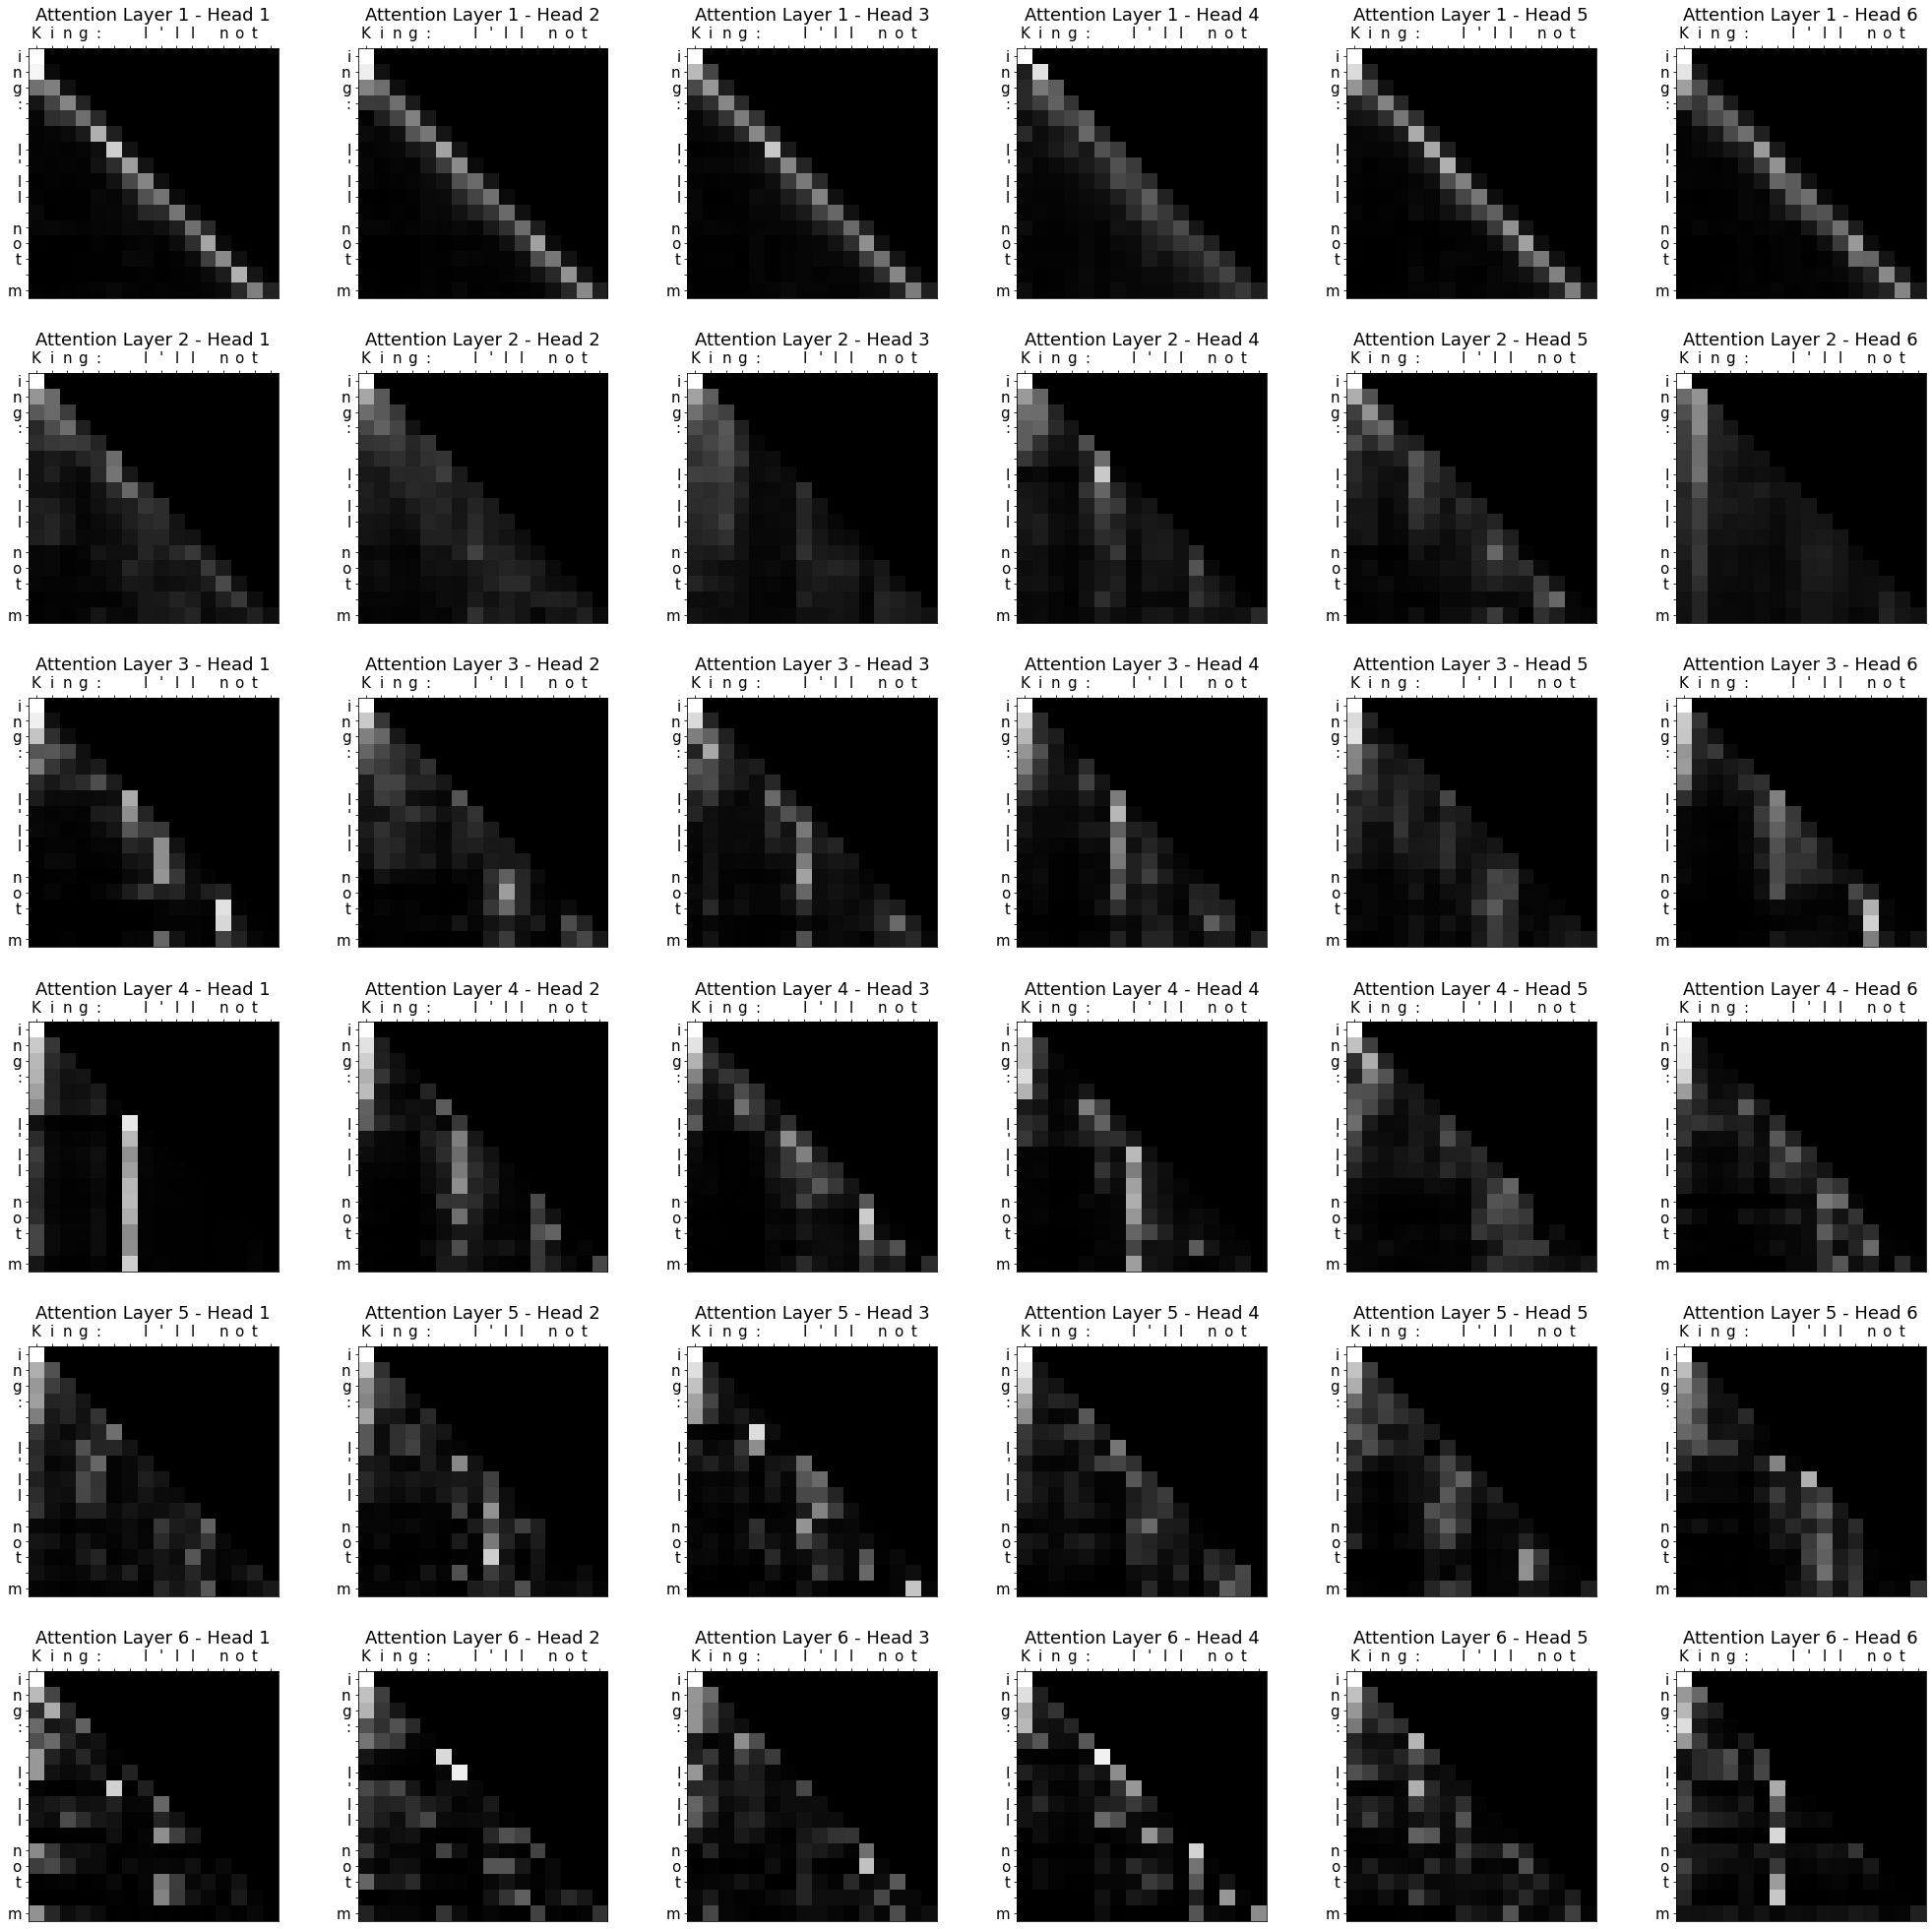

In [43]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(35, 35)) # 6 layers, 6 attention heads

for attention_layer_idx in range(len(attn_list)):   # for each attention layer
    attention_layer_output = attn_list[attention_layer_idx]
    attention_layer_output = attention_layer_output.squeeze(0)           # remove the batch dimension
    
    for attention_head_idx in range(len(attention_layer_output)):    # for each attention head
        attention = attention_layer_output[attention_head_idx]
        attention = attention.detach().cpu().numpy()                  # convert to numpy array
        
        ax = axes[attention_layer_idx, attention_head_idx]
        ax.imshow(attention, cmap='gray', interpolation='nearest')   # # Plot the attention in the current subplot
        
        ax.set_title(f"Attention Layer {attention_layer_idx + 1} - Head {attention_head_idx + 1}", fontsize=18)
        # ax2.set_xticks(range(1, 6), fontsize=15)
        ax.set_xticks(range(len(res)-1), [*res[:-1]], fontsize=15)
        ax.set_yticks(range(len(res)-1), [*res[1:]], fontsize=15)
        
        ax.xaxis.tick_top()
        ax.tick_params(axis='x', which='both', bottom=False, top=True)
        

# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Show the figure
plt.show()
        